# CIS4930 -- Final Project
## Developed by: Chloe Fandino (Team Leader), Ashley James, Madelyne Wirbel, Chloe Nolan, Christopher Enlow

## Data Preprocessing

### Imports

In [120]:
# imports here :)

# TODO: DELETE ---> any imports that don't end up getting used by the end of the project !!!!

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from imblearn.over_sampling import SMOTE, SMOTENC

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

### Loading the data

In [121]:
df = pd.read_csv('OnlineNewsPopularity.csv') # import the data from the csv file --> convert to df

### Exploration of the dataset

In [122]:
# pd.set_option('display.max_rows', 100) # for purposes of looking at data --> need to see all rows

# basic intitial looks at the dataset
print(df.shape)

print(df.info())

(39644, 61)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords       

In [123]:
# Strip whitespace from column names
df.columns = df.columns.str.strip()

In [124]:
print(df.columns.tolist()) # print out all of the available columns

['url', 'timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', '

In [125]:
df.isnull().sum() # null values? --> NONE :)

url                             0
timedelta                       0
n_tokens_title                  0
n_tokens_content                0
n_unique_tokens                 0
                               ..
title_subjectivity              0
title_sentiment_polarity        0
abs_title_subjectivity          0
abs_title_sentiment_polarity    0
shares                          0
Length: 61, dtype: int64

In [126]:
df.duplicated().sum() # duplicate values? --> NONE :)

np.int64(0)

In [127]:
# check if any infinities exist in the dataframe
numeric_df = df.select_dtypes(include=[np.number])

has_inf = np.isinf(numeric_df.to_numpy()).any()

print(has_inf) # will need to handle in cleaning
inf_cols = numeric_df.columns[np.isinf(numeric_df.to_numpy()).any(axis=0)].tolist()
print("Columns with inf:", inf_cols)

False
Columns with inf: []


#### Visualization of the target variable --> shares

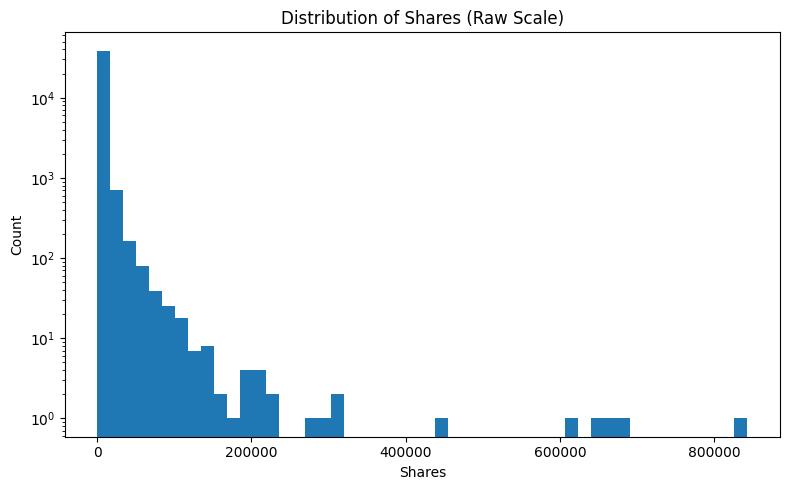

In [128]:
# histogram of shares
plt.figure(figsize=(8, 5))
plt.hist(df["shares"], bins=50)
plt.title("Distribution of Shares (Raw Scale)")
plt.xlabel("Shares")
plt.ylabel("Count")
plt.yscale("log")  # long tail
plt.tight_layout()
plt.show()

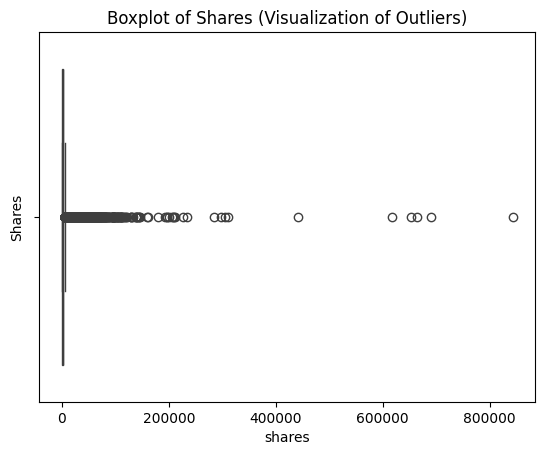

In [129]:
# boxplot of raw shares --> view of the outliers
sns.boxplot(x = df["shares"])
plt.title("Boxplot of Shares (Visualization of Outliers)")
plt.ylabel("Shares")
plt.show()

#### Visualizations of numerical features

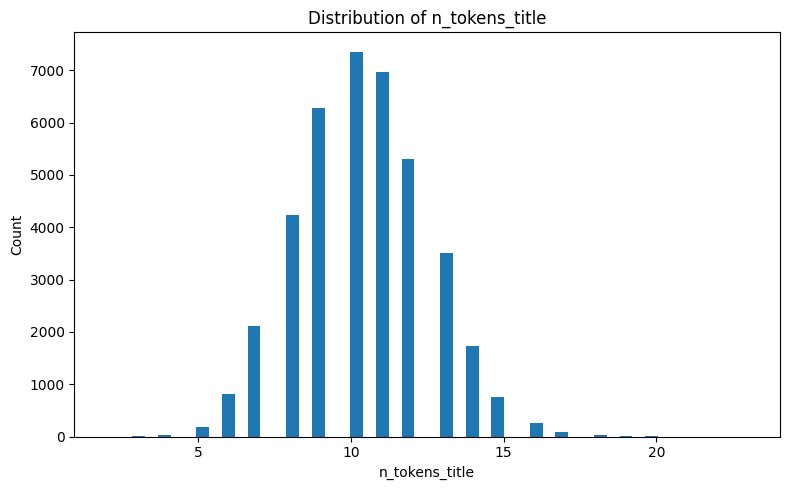

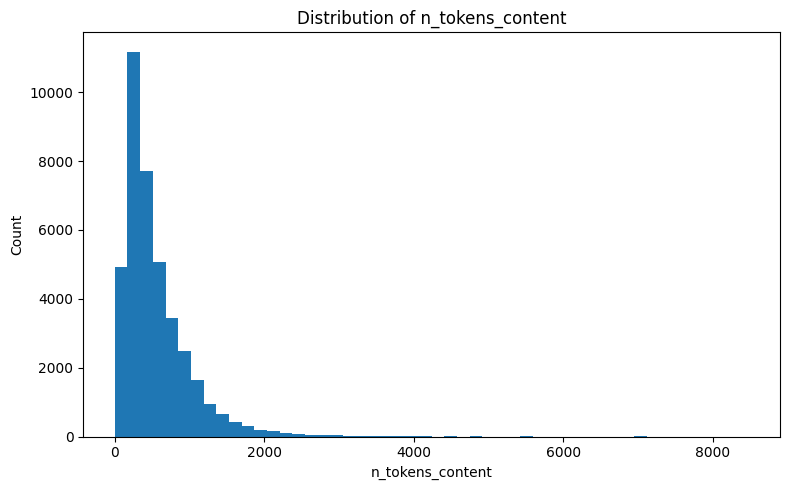

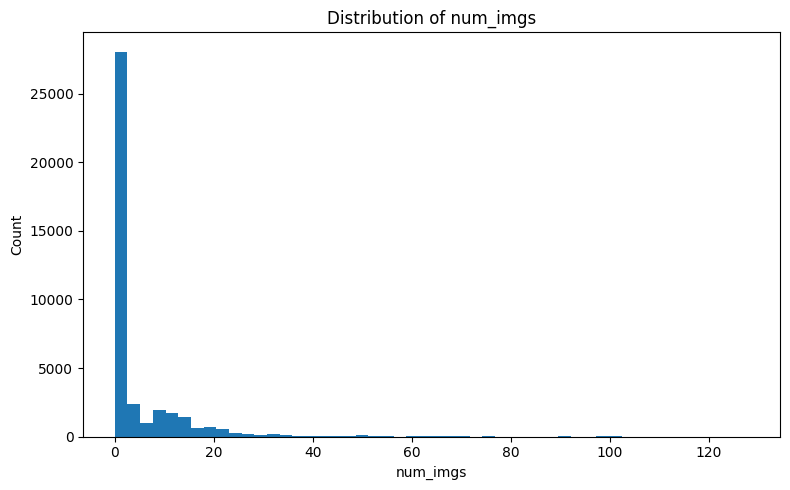

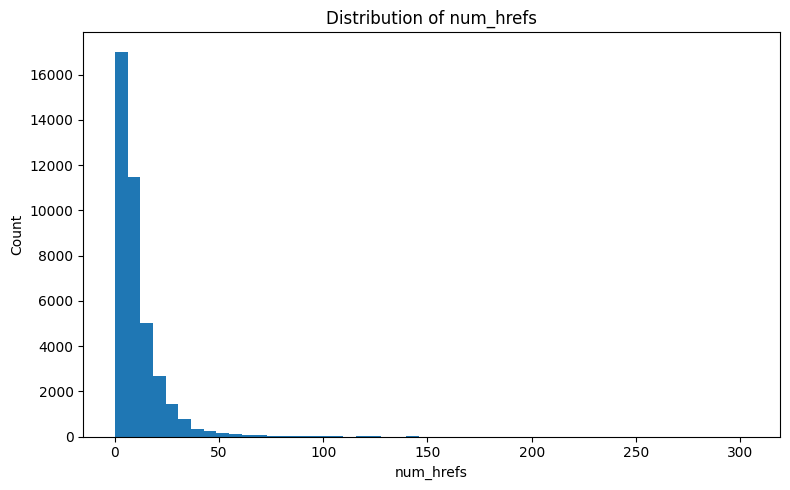

In [130]:
# distribution of key numerical features
key_cols = ["n_tokens_title", "n_tokens_content", "num_imgs", "num_hrefs"]

for col in key_cols:
    plt.figure(figsize=(8, 5))
    plt.hist(df[col], bins=50)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

### Cleaning the data

In [131]:
# # exploration of potentially non-predictive features
df = df.drop(columns=['url', 'timedelta'], errors='ignore') # url is a title and number of days since posted until added to the dataset --> no predictive qualities

# feature engineering
df['rate_positive_words'] = df['global_rate_positive_words'] / (df['n_tokens_content'] + 1)
df['rate_negative_words'] = df['global_rate_negative_words'] / (df['n_tokens_content'] + 1)
df['emotional_polarity'] = df['global_sentiment_polarity'].abs()
df['title_body_sentiment_ratio'] = df['title_sentiment_polarity'] / (df['global_sentiment_polarity'] + 0.01)

In [132]:
# Splitting data in two --> based on median
median_shares = df['shares'].median()
print(f"Splitting data at median shares: {median_shares}")

def categorize(x):
    return 1 if x > median_shares else 0

df['y'] = df['shares'].apply(categorize)

# define X and y 
X = df.drop(columns=['shares', 'y'])
y = df['y']

binary_cols = [col for col in X.columns if "data_channel" in col or "weekday" in col or "is_weekend" in col]
# ensure binary cols are actually integers
for col in binary_cols:
    X[col] = X[col].astype(int)

numeric_cols = [col for col in X.columns if col not in binary_cols]

Splitting data at median shares: 1400.0


In [133]:
# --> test-train-split <-- DO NOT EDIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

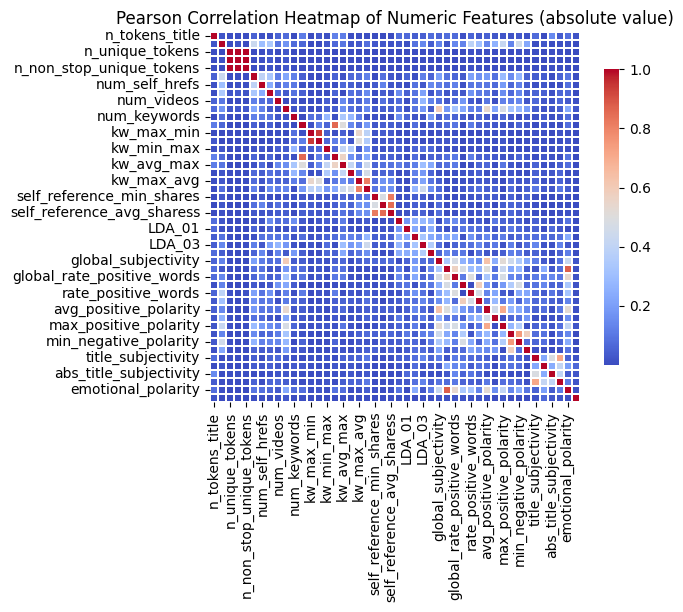

Dropping 6 columns due to correlation: ['n_non_stop_words', 'n_non_stop_unique_tokens', 'kw_avg_min', 'kw_max_max', 'self_reference_avg_sharess', 'emotional_polarity']


In [134]:
#CHLOE pearson correlation coefficient
corr_matrix = X_train[numeric_cols].corr(method='pearson').abs()

# visualization of highly correlated features
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=False,
    linewidths=0.3,
    cbar_kws={"shrink": 0.8},
    square=True
)
plt.title("Pearson Correlation Heatmap of Numeric Features (absolute value)")
plt.show()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

print(f"Dropping {len(to_drop)} columns due to correlation: {to_drop}")

X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
numeric_cols = [c for c in numeric_cols if c not in to_drop]

#### Anomaly Detection

In [135]:
# function to visualize and count anomalies
def anomaly_detection(feature, visualize):
    # first boxplot to see potential outliers
    if visualize:
        sns.boxplot(x = df[feature], color = 'purple')
        plt.title(feature)
        plt.show()

    # second calculate outliers based on IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)

    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    anomalies = df[(df[feature] < lower) | (df[feature] > upper)]
    print('Anomalies: \n', anomalies) # prints a list of potential anomalies

    num_anomalies = anomalies.shape[0]
    return num_anomalies

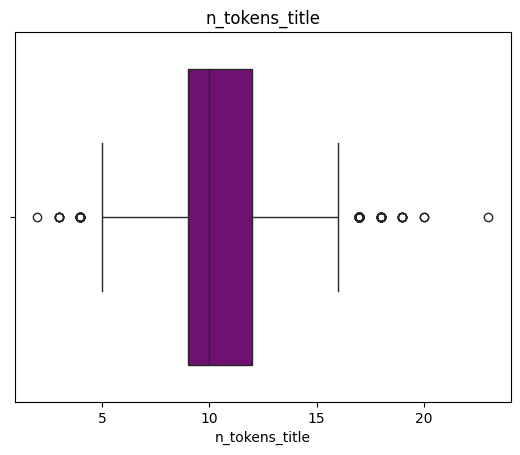

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
588              18.0             355.0         0.551429               1.0   
629               4.0             297.0         0.613014               1.0   
804              18.0             537.0         0.488722               1.0   
861              17.0             141.0         0.770370               1.0   
993               4.0              98.0         0.670213               1.0   
...               ...               ...              ...               ...   
39308            17.0             557.0         0.486388               1.0   
39323            19.0            1140.0         0.394595               1.0   
39390             4.0             589.0         0.509910               1.0   
39460            17.0             262.0         0.605578               1.0   
39534            18.0             406.0         0.587065               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

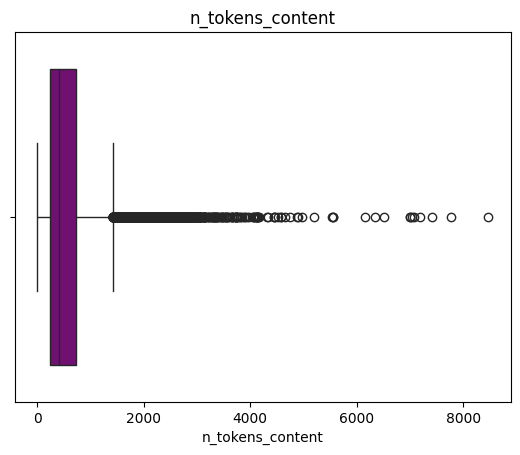

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
140              12.0            1455.0         0.419825               1.0   
141              10.0            1596.0         0.419729               1.0   
316               9.0            1438.0         0.466054               1.0   
336               9.0            1821.0         0.373687               1.0   
393               8.0            1579.0         0.383684               1.0   
...               ...               ...              ...               ...   
39524            15.0            1456.0         0.454674               1.0   
39529            11.0            2377.0         0.241247               1.0   
39593            13.0            1848.0         0.396694               1.0   
39636             8.0            2509.0         0.348878               1.0   
39637            13.0            1629.0         0.425711               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

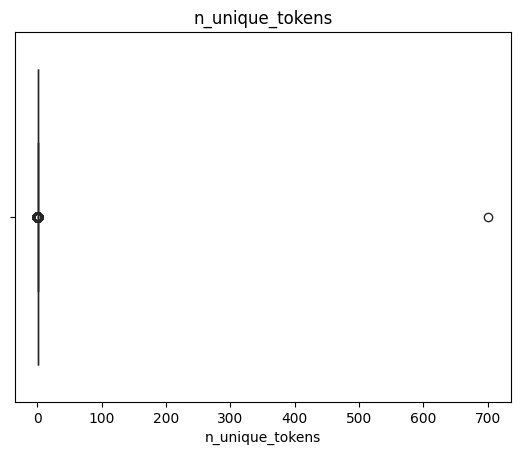

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
57                8.0             130.0         0.821705               1.0   
127               7.0             105.0         0.819048               1.0   
243              12.0              62.0         0.887097               1.0   
244               8.0              75.0         0.853333               1.0   
340              16.0              83.0         0.843373               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

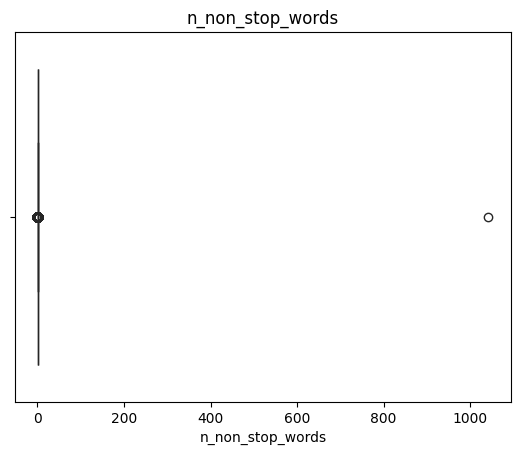

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
18               11.0             103.0         0.689320               1.0   
69                6.0             109.0         0.666667               1.0   
100               9.0             142.0         0.714286               1.0   
119               9.0              81.0         0.787500               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

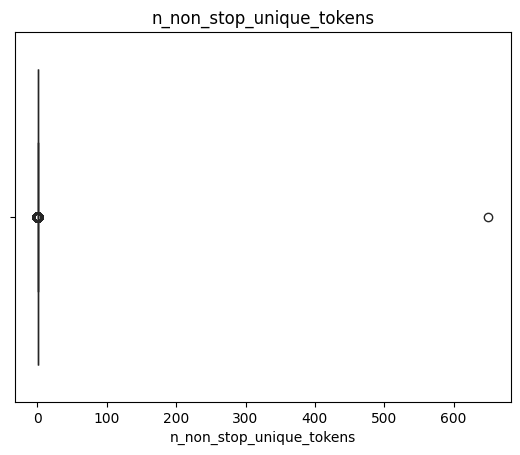

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
244               8.0              75.0         0.853333               1.0   
569               9.0             436.0         0.375870               1.0   
638               7.0              22.0         0.954545               1.0   
717              10.0            1231.0         0.284843               1.0   
773               7.0             524.0         0.309237               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

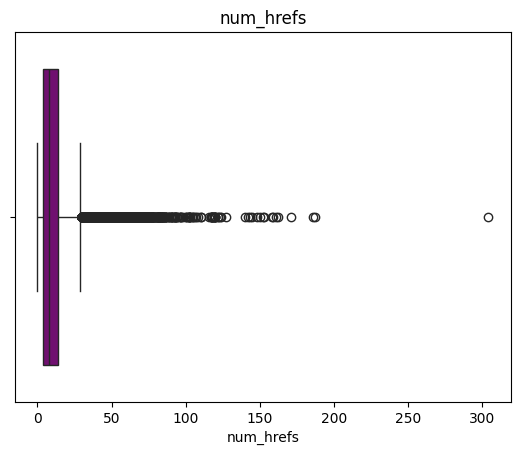

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
98                7.0            1174.0         0.457904               1.0   
103               6.0            1125.0         0.427788               1.0   
140              12.0            1455.0         0.419825               1.0   
147               8.0             794.0         0.503177               1.0   
174              11.0             277.0         0.450185               1.0   
...               ...               ...              ...               ...   
39512            10.0            1058.0         0.404082               1.0   
39558            11.0             428.0         0.559406               1.0   
39596            12.0             270.0         0.594378               1.0   
39612            11.0             735.0         0.505698               1.0   
39617            11.0             991.0         0.459173               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

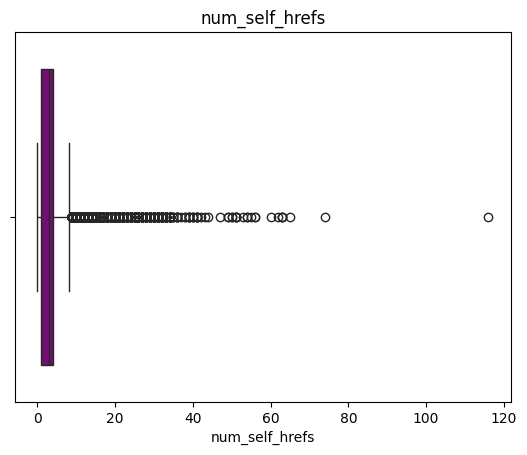

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
4                13.0            1072.0         0.415646               1.0   
6                 8.0             960.0         0.418163               1.0   
7                12.0             989.0         0.433574               1.0   
16                8.0            1118.0         0.512397               1.0   
19                8.0            1207.0         0.410579               1.0   
...               ...               ...              ...               ...   
39532            13.0             961.0         0.499468               1.0   
39606             9.0            1006.0         0.429000               1.0   
39618            14.0             488.0         0.517454               1.0   
39634             9.0             251.0         0.666667               1.0   
39637            13.0            1629.0         0.425711               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

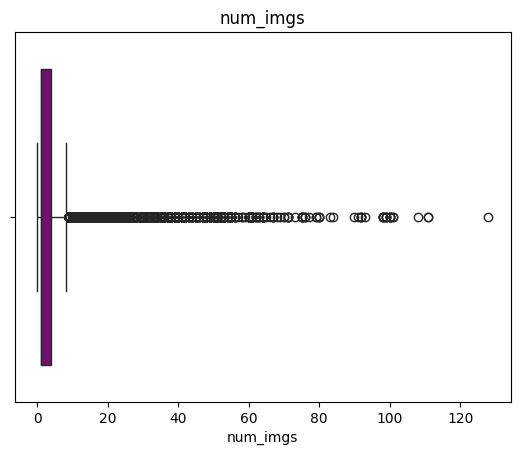

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
4                13.0            1072.0         0.415646               1.0   
6                 8.0             960.0         0.418163               1.0   
7                12.0             989.0         0.433574               1.0   
12                9.0             274.0         0.609195               1.0   
14                8.0             259.0         0.562753               1.0   
...               ...               ...              ...               ...   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39634             9.0             251.0         0.666667               1.0   
39636             8.0            2509.0         0.348878               1.0   
39641            10.0             442.0         0.516355               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

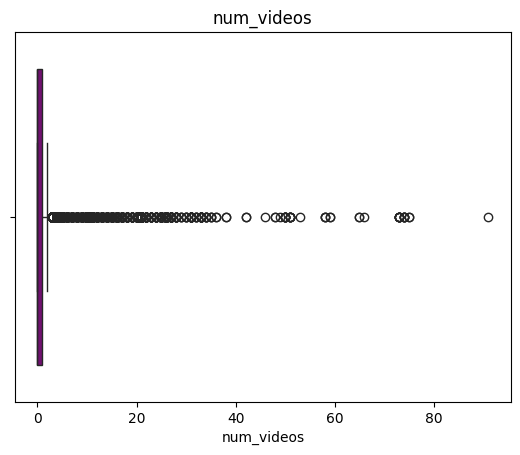

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
47               12.0             161.0         0.668831               1.0   
99                7.0             376.0         0.569014               1.0   
126               8.0             270.0         0.600775               1.0   
129              10.0             254.0         0.627530               1.0   
...               ...               ...              ...               ...   
39529            11.0            2377.0         0.241247               1.0   
39556            12.0             979.0         0.480126               1.0   
39575            13.0             321.0         0.619048               1.0   
39600            11.0            1166.0         0.508254               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

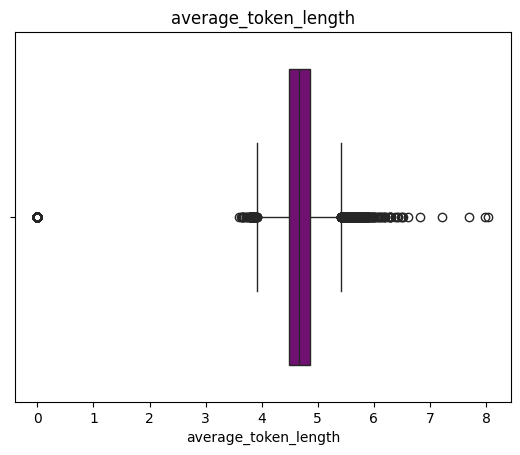

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
17                8.0             397.0         0.624679               1.0   
187               7.0             175.0         0.685714               1.0   
234               7.0             665.0         0.595166               1.0   
242              11.0             149.0         0.673913               1.0   
402              12.0             324.0         0.573248               1.0   
...               ...               ...              ...               ...   
39598            11.0               0.0         0.000000               0.0   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

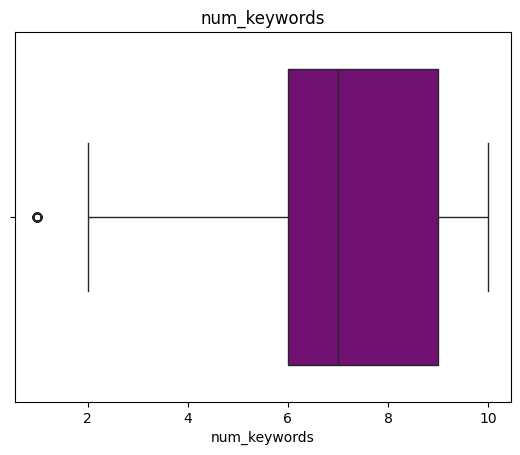

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
1507             11.0             391.0         0.551282               1.0   
1568              9.0             539.0         0.545966               1.0   
2199              9.0             192.0         0.578125               1.0   
3159              8.0             614.0         0.537705               1.0   
4306              9.0            1324.0         0.440154               1.0   
4651              9.0            1214.0         0.458264               1.0   
4868              6.0             139.0         0.625899               1.0   
5234             13.0             146.0         0.753425               1.0   
5617              9.0             463.0         0.543860               1.0   
5771             10.0             128.0         0.724409               1.0   
6320             10.0             822.0         0.480697               1.0   
6395              8.0             481.0         0.5

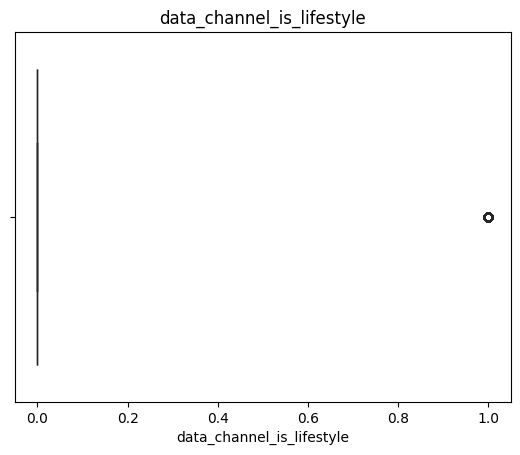

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
6                 8.0             960.0         0.418163               1.0   
11               10.0             187.0         0.666667               1.0   
18               11.0             103.0         0.689320               1.0   
28               10.0             243.0         0.619247               1.0   
34                8.0             204.0         0.586207               1.0   
...               ...               ...              ...               ...   
39557            12.0             908.0         0.455556               1.0   
39596            12.0             270.0         0.594378               1.0   
39599            11.0             610.0         0.510888               1.0   
39608            11.0             575.0         0.530466               1.0   
39636             8.0            2509.0         0.348878               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

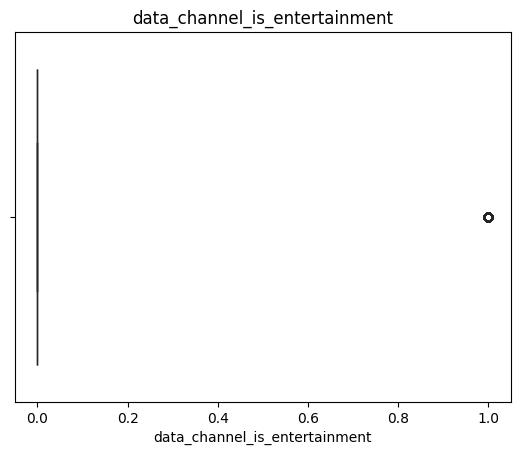

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
3                 9.0             531.0         0.503788               1.0   
39               14.0             194.0         0.764706               1.0   
47               12.0             161.0         0.668831               1.0   
53               11.0             454.0         0.566079               1.0   
...               ...               ...              ...               ...   
39592            11.0             233.0         0.585903               1.0   
39602             9.0             475.0         0.558242               1.0   
39629            13.0             209.0         0.656863               1.0   
39637            13.0            1629.0         0.425711               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

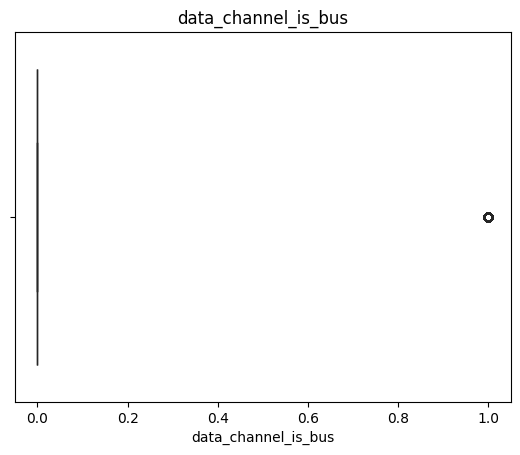

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
17                8.0             397.0         0.624679               1.0   
24               13.0             244.0         0.560000               1.0   
29               11.0             723.0         0.490934               1.0   
...               ...               ...              ...               ...   
39600            11.0            1166.0         0.508254               1.0   
39603            15.0             426.0         0.540284               1.0   
39604            16.0            1020.0         0.421937               1.0   
39635            13.0             478.0         0.514039               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

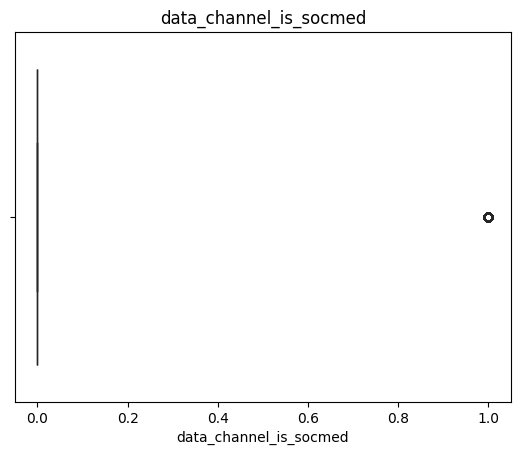

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
37                8.0             257.0         0.568093               1.0   
73                8.0             218.0         0.662983               1.0   
77                9.0            1226.0         0.410172               1.0   
78               10.0            1121.0         0.450679               1.0   
96                9.0             168.0         0.778481               1.0   
...               ...               ...              ...               ...   
39493             9.0             774.0         0.524183               1.0   
39503            12.0             590.0         0.513465               1.0   
39561            13.0             425.0         0.487059               1.0   
39575            13.0             321.0         0.619048               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

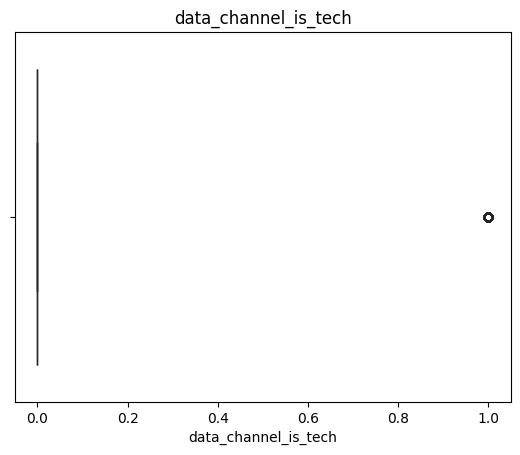

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
4                13.0            1072.0         0.415646               1.0   
5                10.0             370.0         0.559889               1.0   
7                12.0             989.0         0.433574               1.0   
8                11.0              97.0         0.670103               1.0   
19                8.0            1207.0         0.410579               1.0   
...               ...               ...              ...               ...   
39623            14.0             436.0         0.529412               1.0   
39624            12.0             429.0         0.514925               1.0   
39625            13.0             224.0         0.570136               1.0   
39626            12.0             249.0         0.567227               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

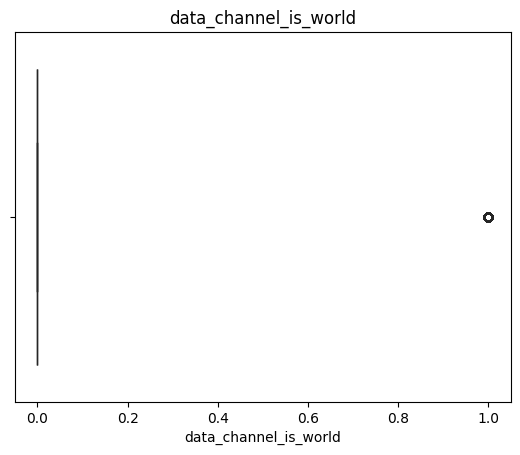

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
9                10.0             231.0         0.636364               1.0   
10                9.0            1248.0         0.490050               1.0   
15               12.0             682.0         0.459542               1.0   
21                9.0             391.0         0.510256               1.0   
23               11.0             125.0         0.674797               1.0   
...               ...               ...              ...               ...   
39630            12.0             491.0         0.454167               1.0   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39633             9.0             614.0         0.476033               1.0   
39642             6.0             682.0         0.539493               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

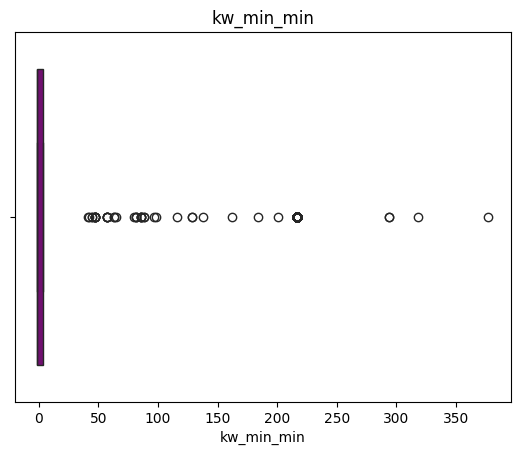

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
79               12.0             288.0         0.589474               1.0   
80               10.0             414.0         0.606796               1.0   
81               11.0             134.0         0.702290               1.0   
82               11.0             281.0         0.610714               1.0   
83               12.0             499.0         0.513026               1.0   
...               ...               ...              ...               ...   
21827             8.0             491.0         0.492754               1.0   
23088            12.0             820.0         0.452645               1.0   
23257            10.0             232.0         0.495370               1.0   
23325            10.0             293.0         0.582734               1.0   
23691             7.0             328.0         0.640678               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

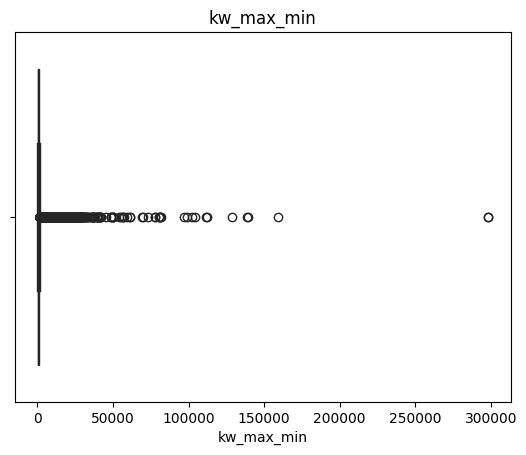

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
87               13.0             306.0         0.534653               1.0   
100               9.0             142.0         0.714286               1.0   
104              10.0             498.0         0.534979               1.0   
107              11.0             223.0         0.662162               1.0   
109               7.0            1007.0         0.437751               1.0   
...               ...               ...              ...               ...   
39581            11.0            1066.0         0.461538               1.0   
39587            13.0             364.0         0.538462               1.0   
39590            11.0            1143.0         0.450088               1.0   
39621             9.0             468.0         0.582781               1.0   
39625            13.0             224.0         0.570136               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

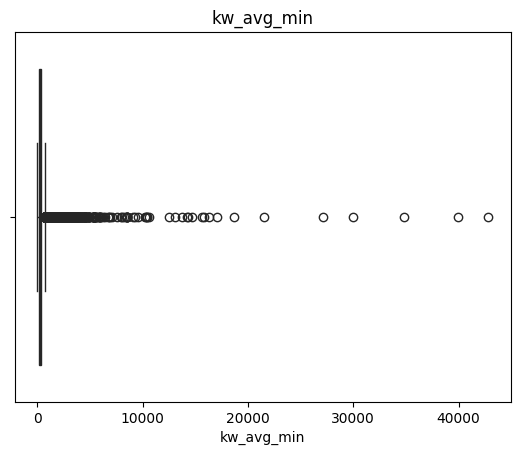

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
87               13.0             306.0         0.534653               1.0   
100               9.0             142.0         0.714286               1.0   
104              10.0             498.0         0.534979               1.0   
107              11.0             223.0         0.662162               1.0   
109               7.0            1007.0         0.437751               1.0   
...               ...               ...              ...               ...   
39517            12.0            1002.0         0.444329               1.0   
39518            14.0             932.0         0.501650               1.0   
39520            10.0             572.0         0.521739               1.0   
39531             7.0             763.0         0.492578               1.0   
39587            13.0             364.0         0.538462               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

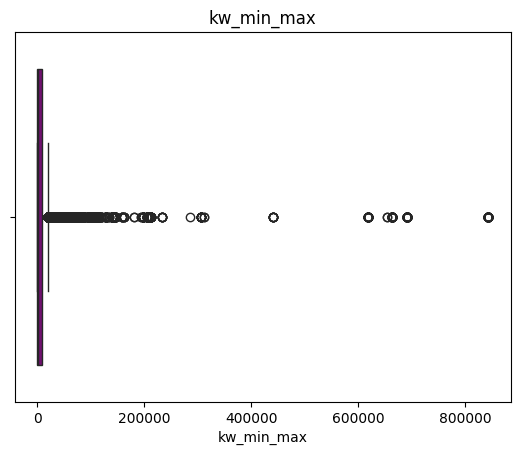

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
400              10.0             342.0         0.606707               1.0   
448              12.0             803.0         0.496241               1.0   
571               7.0             340.0         0.587537               1.0   
573              10.0             311.0         0.659091               1.0   
602              14.0             326.0         0.553125               1.0   
...               ...               ...              ...               ...   
39629            13.0             209.0         0.656863               1.0   
39631            13.0             746.0         0.465306               1.0   
39636             8.0            2509.0         0.348878               1.0   
39639            11.0             346.0         0.529052               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

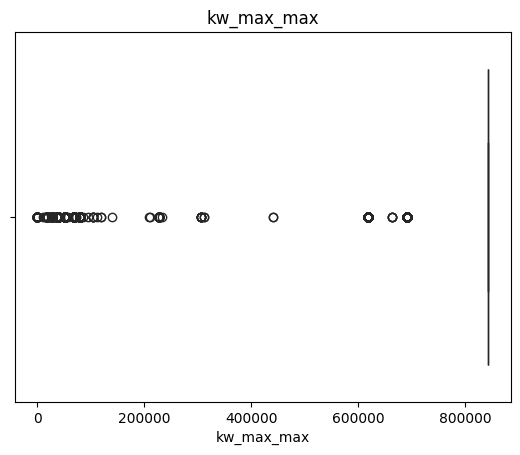

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
3                 9.0             531.0         0.503788               1.0   
4                13.0            1072.0         0.415646               1.0   
...               ...               ...              ...               ...   
29853            10.0            1931.0         0.433438               1.0   
33009            11.0             825.0         0.362595               1.0   
35865            10.0               0.0         0.000000               0.0   
39147            11.0            1467.0         0.432056               1.0   
39155            13.0            1513.0         0.422043               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

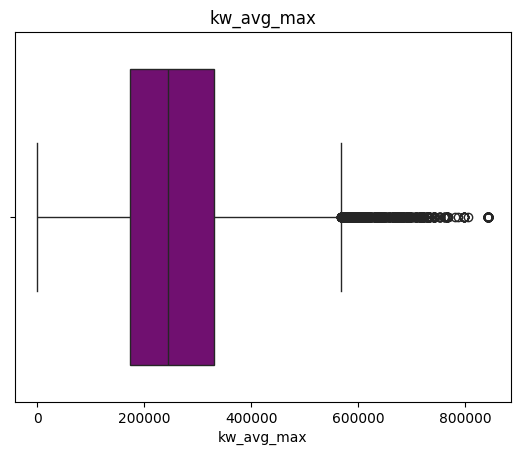

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
3159              8.0             614.0         0.537705               1.0   
4306              9.0            1324.0         0.440154               1.0   
4582             11.0             310.0         0.719858               1.0   
4651              9.0            1214.0         0.458264               1.0   
4855             13.0             147.0         0.734694               1.0   
...               ...               ...              ...               ...   
39538             9.0               0.0         0.000000               0.0   
39560             9.0             261.0         0.620553               1.0   
39600            11.0            1166.0         0.508254               1.0   
39601            12.0               0.0         0.000000               0.0   
39626            12.0             249.0         0.567227               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

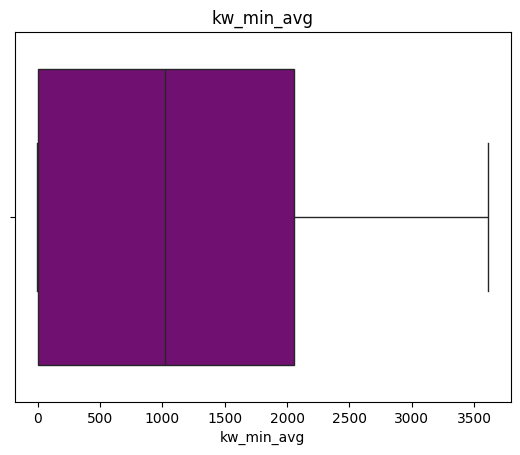

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

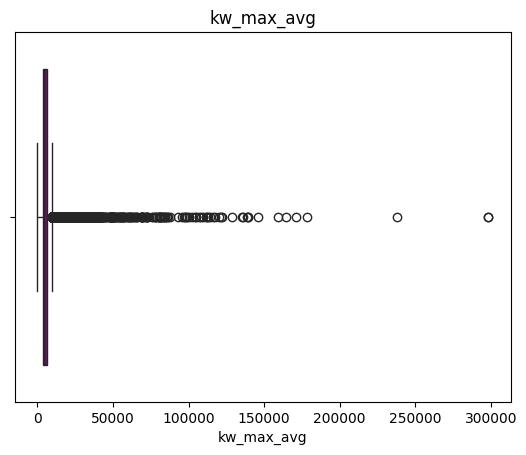

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
113              11.0             825.0         0.476601               1.0   
126               8.0             270.0         0.600775               1.0   
137              13.0             281.0         0.605263               1.0   
145              10.0             138.0         0.753731               1.0   
176              14.0             114.0         0.800000               1.0   
...               ...               ...              ...               ...   
39520            10.0             572.0         0.521739               1.0   
39531             7.0             763.0         0.492578               1.0   
39537             9.0             174.0         0.726190               1.0   
39586            12.0             318.0         0.553398               1.0   
39629            13.0             209.0         0.656863               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

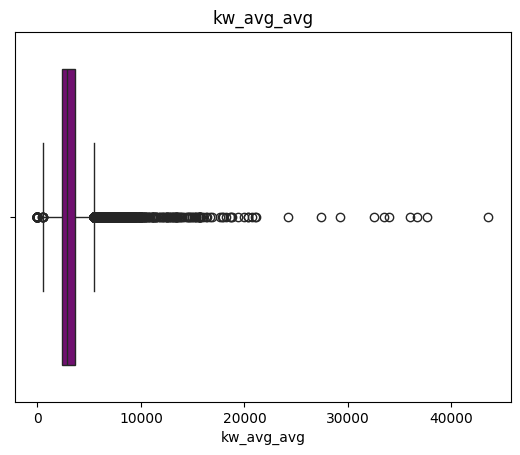

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
3                 9.0             531.0         0.503788               1.0   
4                13.0            1072.0         0.415646               1.0   
...               ...               ...              ...               ...   
39541            11.0               0.0         0.000000               0.0   
39569            15.0               0.0         0.000000               0.0   
39586            12.0             318.0         0.553398               1.0   
39588            10.0             759.0         0.523352               1.0   
39601            12.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

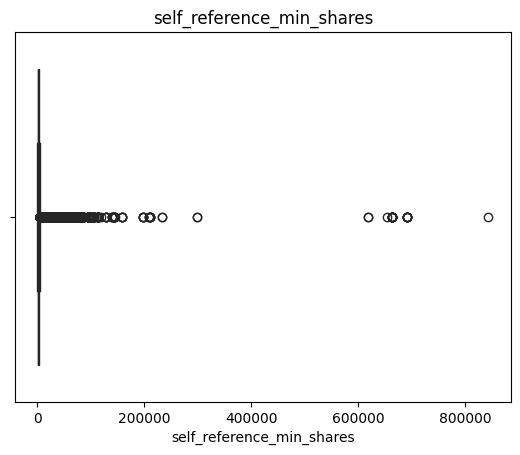

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
5                10.0             370.0         0.559889               1.0   
12                9.0             274.0         0.609195               1.0   
23               11.0             125.0         0.674797               1.0   
30                8.0             708.0         0.482219               1.0   
35               11.0             315.0         0.551282               1.0   
...               ...               ...              ...               ...   
39607             9.0             376.0         0.545190               1.0   
39611            12.0             270.0         0.604651               1.0   
39621             9.0             468.0         0.582781               1.0   
39635            13.0             478.0         0.514039               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

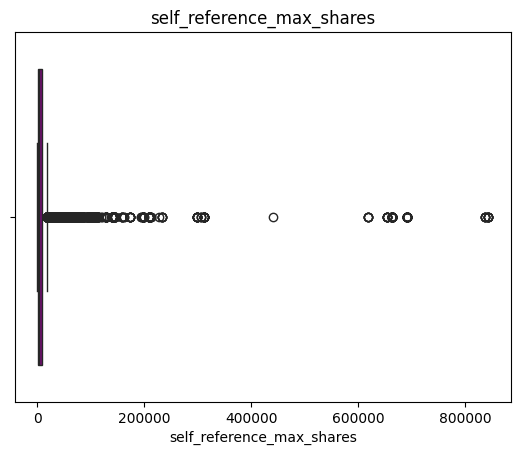

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
47               12.0             161.0         0.668831               1.0   
88               10.0             909.0         0.449612               1.0   
117               7.0             346.0         0.564565               1.0   
147               8.0             794.0         0.503177               1.0   
...               ...               ...              ...               ...   
39478            15.0             783.0         0.470817               1.0   
39505            15.0             447.0         0.551570               1.0   
39524            15.0            1456.0         0.454674               1.0   
39621             9.0             468.0         0.582781               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

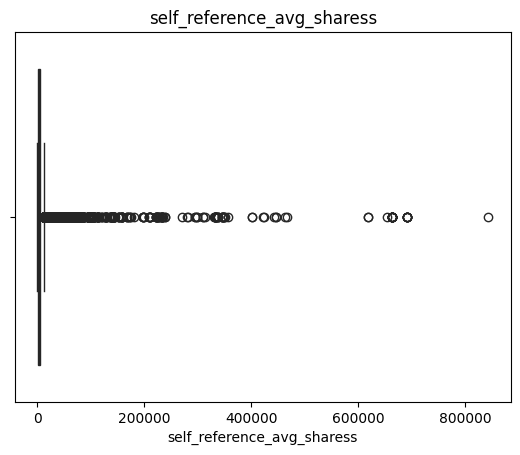

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
23               11.0             125.0         0.674797               1.0   
88               10.0             909.0         0.449612               1.0   
107              11.0             223.0         0.662162               1.0   
...               ...               ...              ...               ...   
39498            12.0             758.0         0.486188               1.0   
39524            15.0            1456.0         0.454674               1.0   
39607             9.0             376.0         0.545190               1.0   
39621             9.0             468.0         0.582781               1.0   
39639            11.0             346.0         0.529052               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

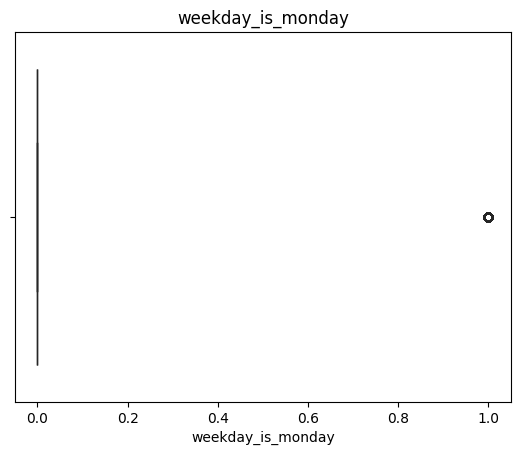

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
1                 9.0             255.0         0.604743               1.0   
2                 9.0             211.0         0.575130               1.0   
3                 9.0             531.0         0.503788               1.0   
4                13.0            1072.0         0.415646               1.0   
...               ...               ...              ...               ...   
39574            13.0             367.0         0.534819               1.0   
39575            13.0             321.0         0.619048               1.0   
39576            12.0             454.0         0.607477               1.0   
39577            11.0             363.0         0.594828               1.0   
39578            11.0             287.0         0.602151               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

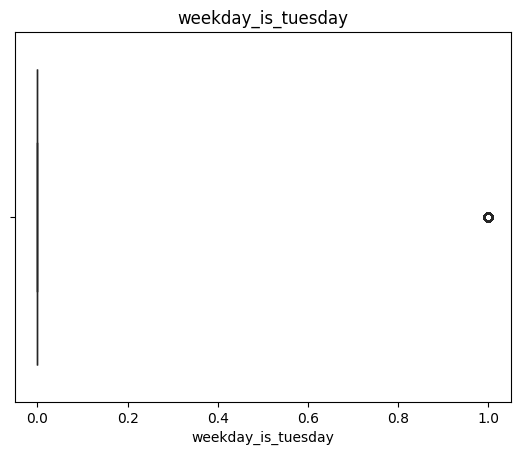

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
79               12.0             288.0         0.589474               1.0   
80               10.0             414.0         0.606796               1.0   
81               11.0             134.0         0.702290               1.0   
82               11.0             281.0         0.610714               1.0   
83               12.0             499.0         0.513026               1.0   
...               ...               ...              ...               ...   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39633             9.0             614.0         0.476033               1.0   
39634             9.0             251.0         0.666667               1.0   
39635            13.0             478.0         0.514039               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

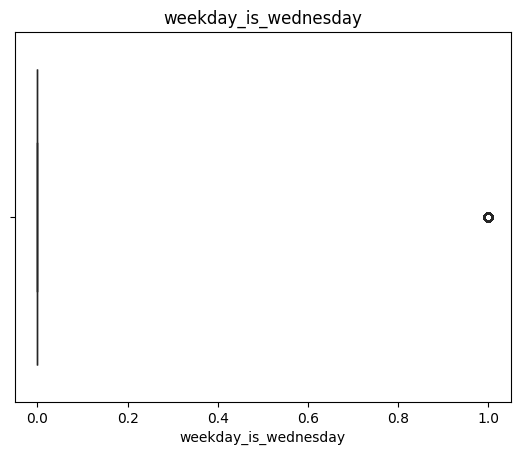

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
91               10.0             413.0         0.606436               1.0   
92                9.0             180.0         0.630058               1.0   
93                9.0             759.0         0.498667               1.0   
94               13.0            1226.0         0.436197               1.0   
95                6.0             241.0         0.659574               1.0   
...               ...               ...              ...               ...   
39639            11.0             346.0         0.529052               1.0   
39640            12.0             328.0         0.696296               1.0   
39641            10.0             442.0         0.516355               1.0   
39642             6.0             682.0         0.539493               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

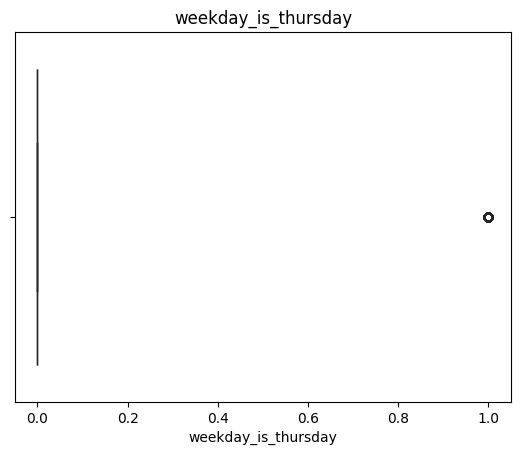

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
180               7.0             144.0         0.591549               1.0   
181               9.0             760.0         0.531629               1.0   
182              13.0             204.0         0.646465               1.0   
183              15.0             481.0         0.541053               1.0   
184              12.0             246.0         0.702128               1.0   
...               ...               ...              ...               ...   
39426            11.0               0.0         0.000000               0.0   
39427            11.0             820.0         0.497512               1.0   
39428            11.0               0.0         0.000000               0.0   
39429             9.0             952.0         0.442797               1.0   
39430            10.0             392.0         0.509333               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

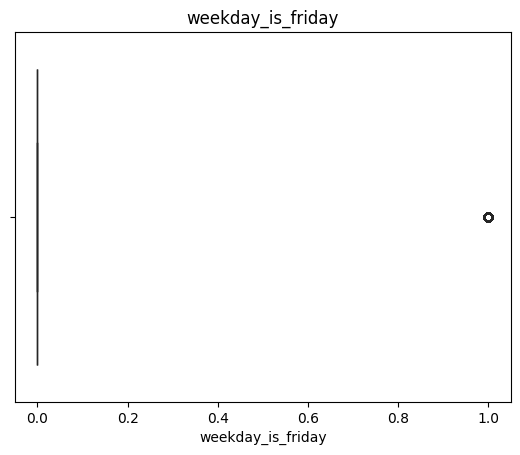

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
260              12.0             698.0         0.498534               1.0   
261              13.0             310.0         0.612457               1.0   
262               8.0             461.0         0.550000               1.0   
263               9.0             318.0         0.579288               1.0   
264              10.0             294.0         0.703008               1.0   
...               ...               ...              ...               ...   
39467            11.0             791.0         0.476882               1.0   
39468            14.0            1025.0         0.465139               1.0   
39469            10.0             559.0         0.539741               1.0   
39470             8.0             996.0         0.485804               1.0   
39471            13.0            1300.0         0.411810               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

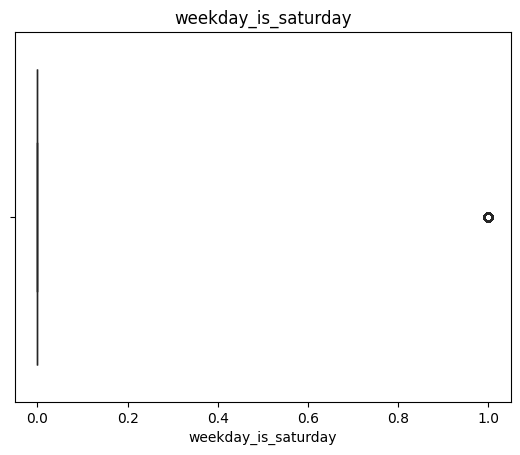

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
311               7.0             203.0         0.668367               1.0   
312              11.0             351.0         0.521490               1.0   
313              11.0             566.0         0.553114               1.0   
314              13.0             297.0         0.532203               1.0   
315               8.0             104.0         0.754902               1.0   
...               ...               ...              ...               ...   
39487            11.0             303.0         0.601351               1.0   
39488            12.0             181.0         0.628571               1.0   
39489            12.0               0.0         0.000000               0.0   
39490            10.0             914.0         0.498343               1.0   
39491             8.0             510.0         0.563636               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

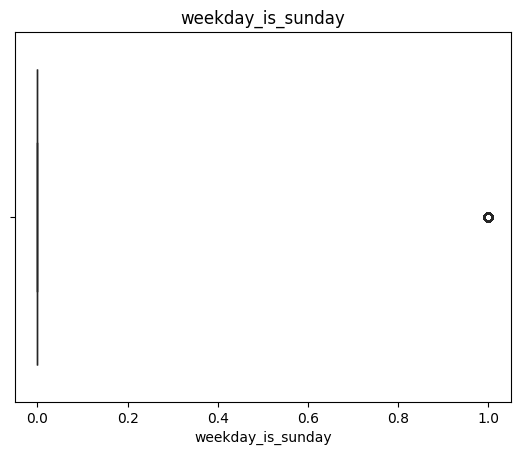

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
331              10.0             996.0         0.490375               1.0   
332              10.0             331.0         0.691318               1.0   
333              10.0             497.0         0.533881               1.0   
334               9.0             678.0         0.493274               1.0   
335               7.0             211.0         0.636364               1.0   
...               ...               ...              ...               ...   
39512            10.0            1058.0         0.404082               1.0   
39513            10.0               0.0         0.000000               0.0   
39514            13.0             813.0         0.415906               1.0   
39515             7.0               0.0         0.000000               0.0   
39516            13.0             936.0         0.426230               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

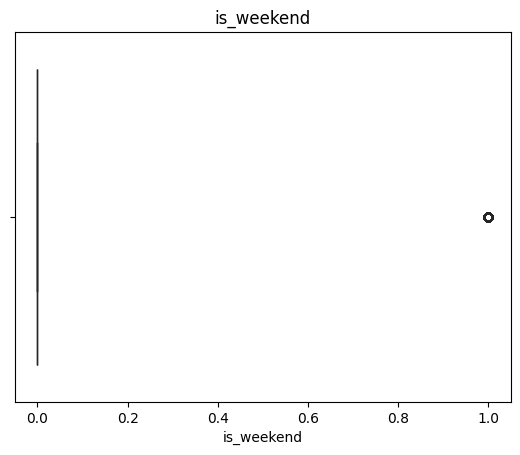

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
311               7.0             203.0         0.668367               1.0   
312              11.0             351.0         0.521490               1.0   
313              11.0             566.0         0.553114               1.0   
314              13.0             297.0         0.532203               1.0   
315               8.0             104.0         0.754902               1.0   
...               ...               ...              ...               ...   
39512            10.0            1058.0         0.404082               1.0   
39513            10.0               0.0         0.000000               0.0   
39514            13.0             813.0         0.415906               1.0   
39515             7.0               0.0         0.000000               0.0   
39516            13.0             936.0         0.426230               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

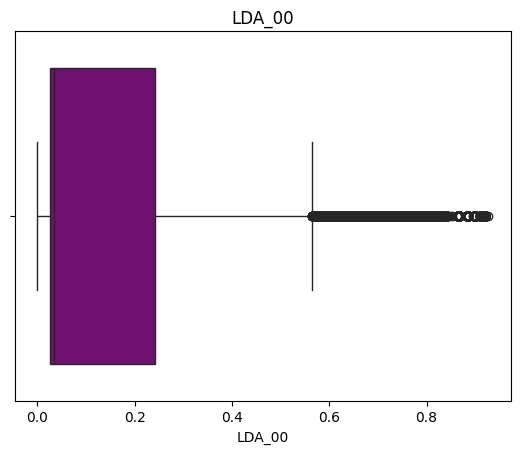

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
1                 9.0             255.0         0.604743               1.0   
17                8.0             397.0         0.624679               1.0   
29               11.0             723.0         0.490934               1.0   
30                8.0             708.0         0.482219               1.0   
93                9.0             759.0         0.498667               1.0   
...               ...               ...              ...               ...   
39590            11.0            1143.0         0.450088               1.0   
39600            11.0            1166.0         0.508254               1.0   
39603            15.0             426.0         0.540284               1.0   
39604            16.0            1020.0         0.421937               1.0   
39635            13.0             478.0         0.514039               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

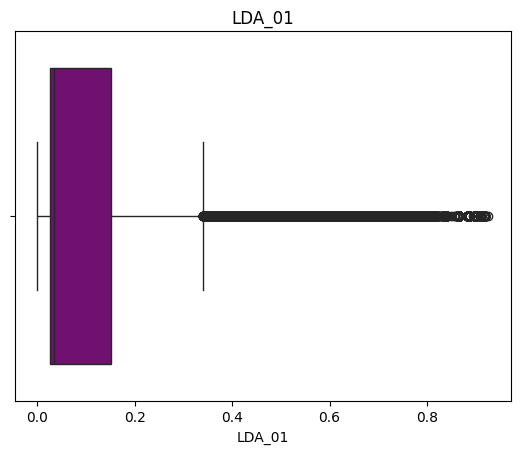

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0                12.0             219.0         0.663594               1.0   
3                 9.0             531.0         0.503788               1.0   
25                8.0             266.0         0.572581               1.0   
27               12.0            1225.0         0.385452               1.0   
43               10.0            1081.0         0.428037               1.0   
...               ...               ...              ...               ...   
39602             9.0             475.0         0.558242               1.0   
39619            14.0             428.0         0.512881               1.0   
39620            13.0             413.0         0.556675               1.0   
39637            13.0            1629.0         0.425711               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

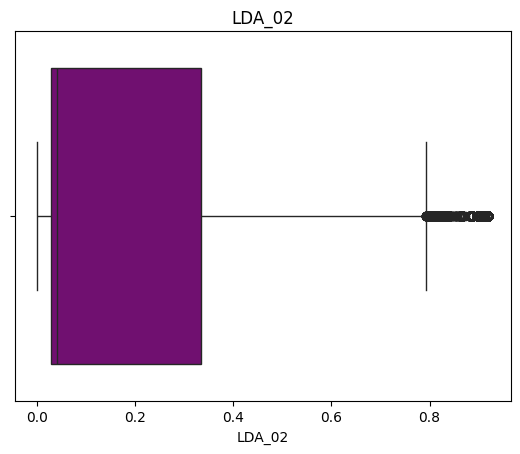

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
9                10.0             231.0         0.636364               1.0   
15               12.0             682.0         0.459542               1.0   
38               11.0             799.0         0.504391               1.0   
67               11.0             317.0         0.611465               1.0   
79               12.0             288.0         0.589474               1.0   
...               ...               ...              ...               ...   
39628            14.0             626.0         0.552504               1.0   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39633             9.0             614.0         0.476033               1.0   
39642             6.0             682.0         0.539493               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

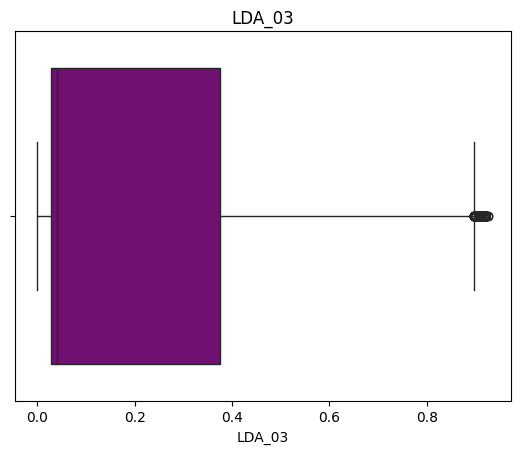

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
96                9.0             168.0         0.778481               1.0   
271              12.0             341.0         0.498471               1.0   
332              10.0             331.0         0.691318               1.0   
342               6.0             279.0         0.650000               1.0   
350              12.0            1267.0         0.502034               1.0   
...               ...               ...              ...               ...   
39541            11.0               0.0         0.000000               0.0   
39546            14.0             466.0         0.520607               1.0   
39569            15.0               0.0         0.000000               0.0   
39580            11.0             459.0         0.534940               1.0   
39584            11.0               0.0         0.000000               0.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

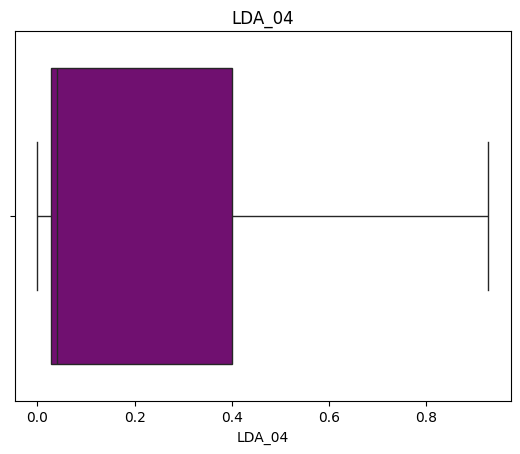

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

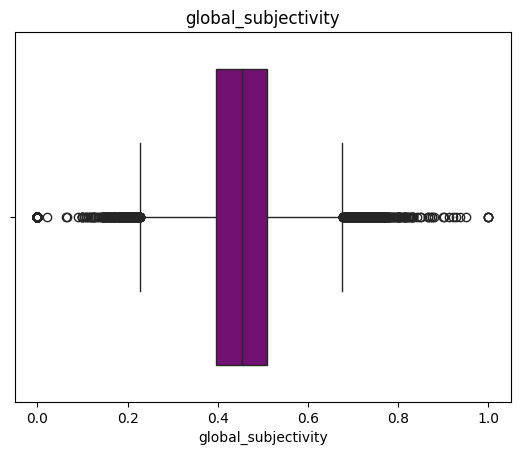

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
2                 9.0             211.0         0.575130               1.0   
111               9.0             233.0         0.552885               1.0   
112               9.0             167.0         0.680982               1.0   
152               7.0             142.0         0.732394               1.0   
221              12.0             160.0         0.647799               1.0   
...               ...               ...              ...               ...   
39601            12.0               0.0         0.000000               0.0   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   
39634             9.0             251.0         0.666667               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

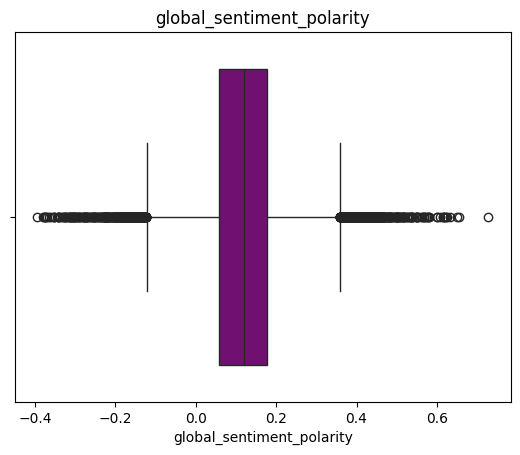

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
178               8.0             211.0         0.607655               1.0   
180               7.0             144.0         0.591549               1.0   
261              13.0             310.0         0.612457               1.0   
274              11.0             221.0         0.660550               1.0   
304              12.0             337.0         0.611987               1.0   
...               ...               ...              ...               ...   
39238             9.0             586.0         0.455342               1.0   
39364            11.0             410.0         0.501235               1.0   
39395            10.0             174.0         0.596154               1.0   
39433            14.0             146.0         0.604651               1.0   
39444             8.0             286.0         0.589744               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

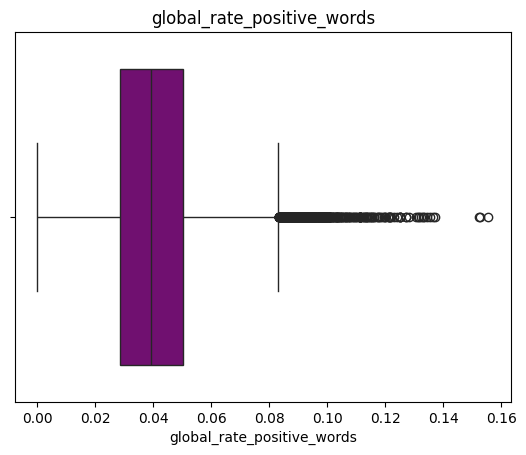

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
7                12.0             989.0         0.433574               1.0   
69                6.0             109.0         0.666667               1.0   
89               12.0             999.0         0.424089               1.0   
101               9.0             825.0         0.438037               1.0   
134               8.0             935.0         0.442037               1.0   
...               ...               ...              ...               ...   
38748            11.0             338.0         0.477564               1.0   
38937             9.0             656.0         0.411856               1.0   
39238             9.0             586.0         0.455342               1.0   
39387            12.0              93.0         0.750000               1.0   
39448            11.0             872.0         0.427562               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

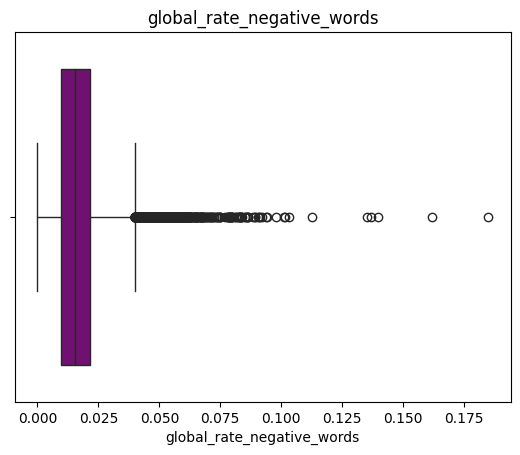

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
66                7.0             251.0         0.615702               1.0   
96                9.0             168.0         0.778481               1.0   
115               7.0             263.0         0.623077               1.0   
176              14.0             114.0         0.800000               1.0   
...               ...               ...              ...               ...   
39395            10.0             174.0         0.596154               1.0   
39408            10.0             471.0         0.538803               1.0   
39412            13.0              99.0         0.762887               1.0   
39433            14.0             146.0         0.604651               1.0   
39576            12.0             454.0         0.607477               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

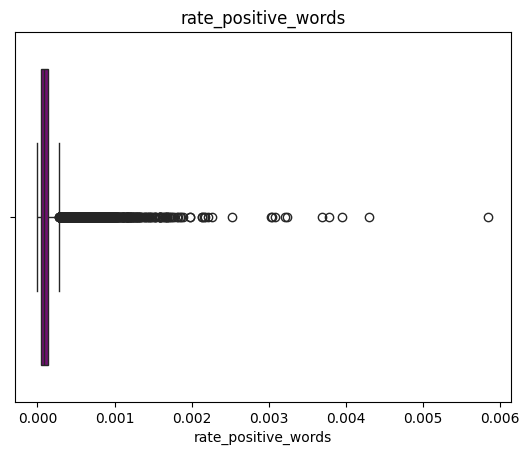

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
23               11.0             125.0         0.674797               1.0   
34                8.0             204.0         0.586207               1.0   
39               14.0             194.0         0.764706               1.0   
47               12.0             161.0         0.668831               1.0   
...               ...               ...              ...               ...   
39274            10.0             114.0         0.687500               1.0   
39353            11.0              79.0         0.766234               1.0   
39367            10.0             182.0         0.685083               1.0   
39387            12.0              93.0         0.750000               1.0   
39643            10.0             157.0         0.701987               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

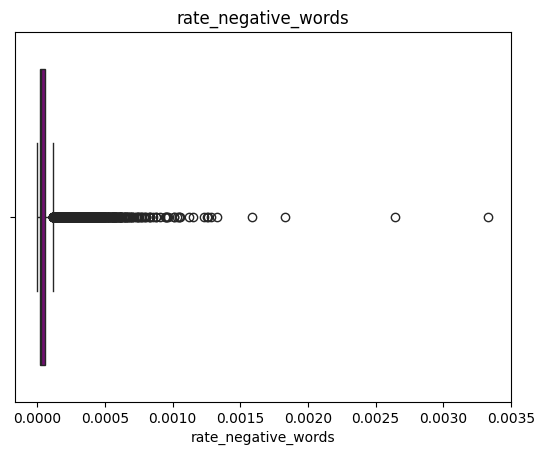

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
9                10.0             231.0         0.636364               1.0   
13                9.0             285.0         0.744186               1.0   
66                7.0             251.0         0.615702               1.0   
69                6.0             109.0         0.666667               1.0   
...               ...               ...              ...               ...   
39482             9.0             169.0         0.636905               1.0   
39509             9.0             207.0         0.611650               1.0   
39537             9.0             174.0         0.726190               1.0   
39552             7.0             256.0         0.596838               1.0   
39562             8.0             230.0         0.642534               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

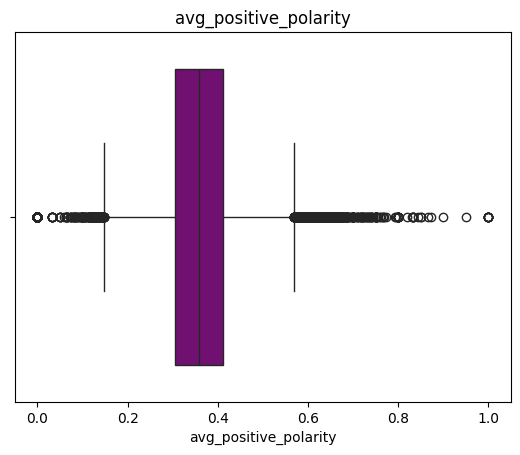

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
145              10.0             138.0         0.753731               1.0   
156              11.0             173.0         0.723529               1.0   
168               9.0             230.0         0.669604               1.0   
180               7.0             144.0         0.591549               1.0   
204               9.0             152.0         0.622378               1.0   
...               ...               ...              ...               ...   
39613            12.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39616            15.0               0.0         0.000000               0.0   
39634             9.0             251.0         0.666667               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

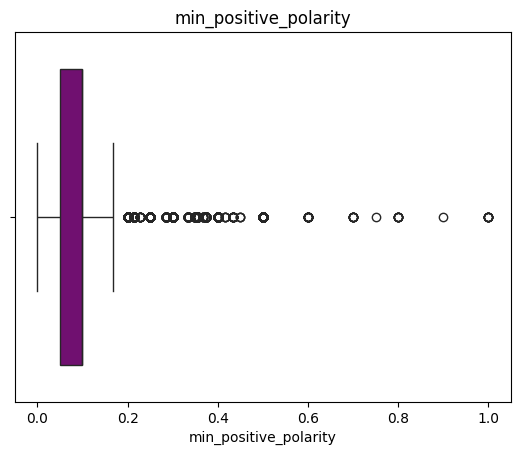

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
8                11.0              97.0         0.670103               1.0   
11               10.0             187.0         0.666667               1.0   
12                9.0             274.0         0.609195               1.0   
25                8.0             266.0         0.572581               1.0   
45               10.0             142.0         0.654676               1.0   
...               ...               ...              ...               ...   
39591            11.0             247.0         0.589212               1.0   
39611            12.0             270.0         0.604651               1.0   
39629            13.0             209.0         0.656863               1.0   
39634             9.0             251.0         0.666667               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

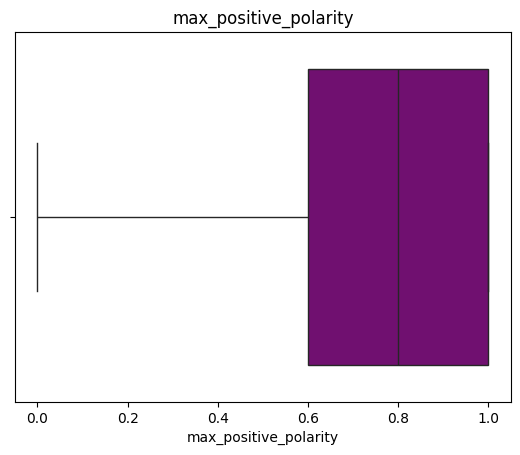

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

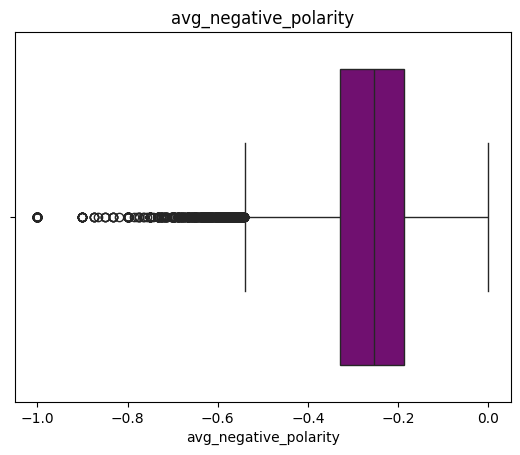

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
152               7.0             142.0         0.732394               1.0   
156              11.0             173.0         0.723529               1.0   
215              13.0             309.0         0.618893               1.0   
327              12.0             138.0         0.644928               1.0   
364              12.0             315.0         0.537162               1.0   
...               ...               ...              ...               ...   
39488            12.0             181.0         0.628571               1.0   
39508            12.0             496.0         0.521368               1.0   
39575            13.0             321.0         0.619048               1.0   
39628            14.0             626.0         0.552504               1.0   
39634             9.0             251.0         0.666667               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

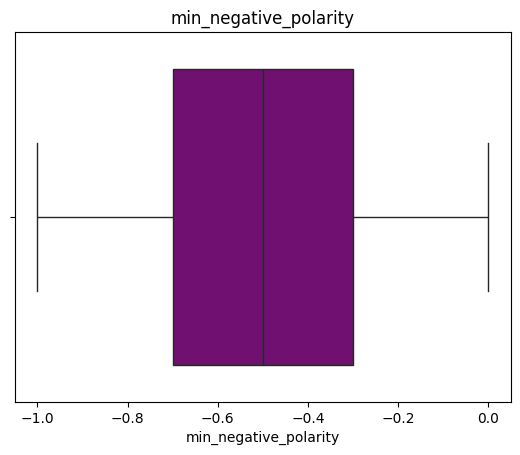

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

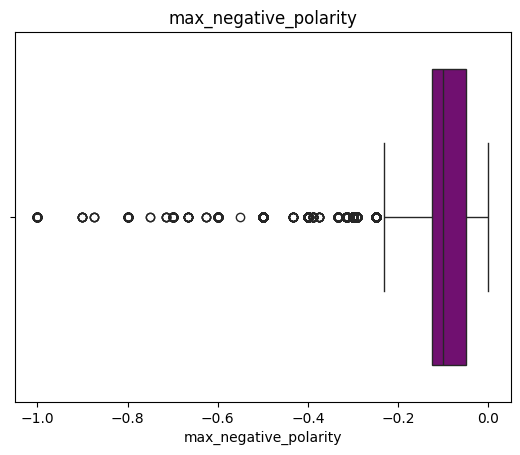

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
34                8.0             204.0         0.586207               1.0   
45               10.0             142.0         0.654676               1.0   
50               11.0             214.0         0.644550               1.0   
57                8.0             130.0         0.821705               1.0   
84                9.0             268.0         0.477273               1.0   
...               ...               ...              ...               ...   
39488            12.0             181.0         0.628571               1.0   
39508            12.0             496.0         0.521368               1.0   
39564            11.0             356.0         0.615607               1.0   
39620            13.0             413.0         0.556675               1.0   
39638            11.0             223.0         0.653153               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

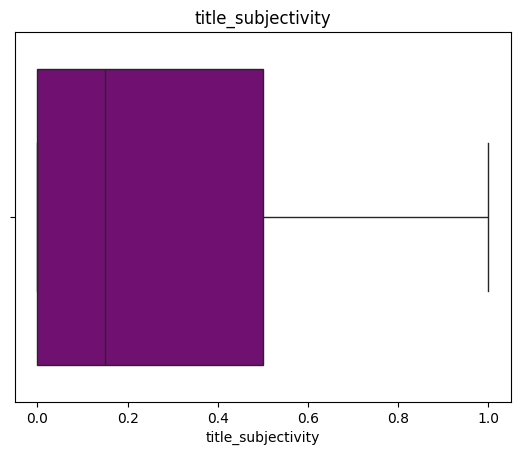

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

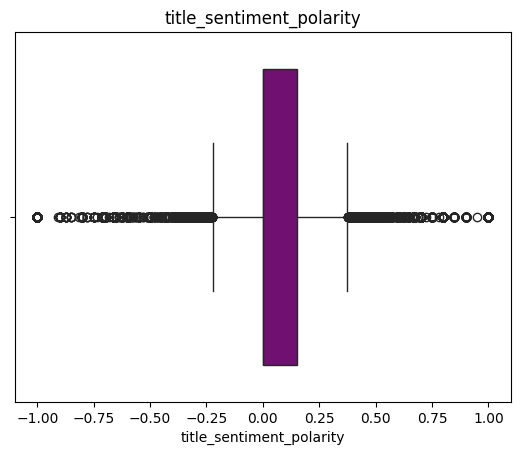

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
7                12.0             989.0         0.433574               1.0   
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
14                8.0             259.0         0.562753               1.0   
15               12.0             682.0         0.459542               1.0   
...               ...               ...              ...               ...   
39629            13.0             209.0         0.656863               1.0   
39631            13.0             746.0         0.465306               1.0   
39632            15.0             580.0         0.506261               1.0   
39637            13.0            1629.0         0.425711               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

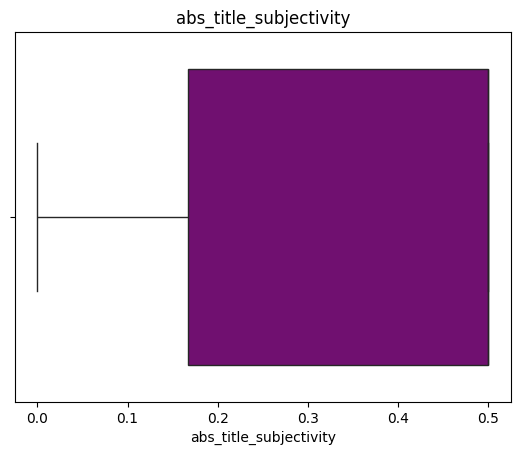

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

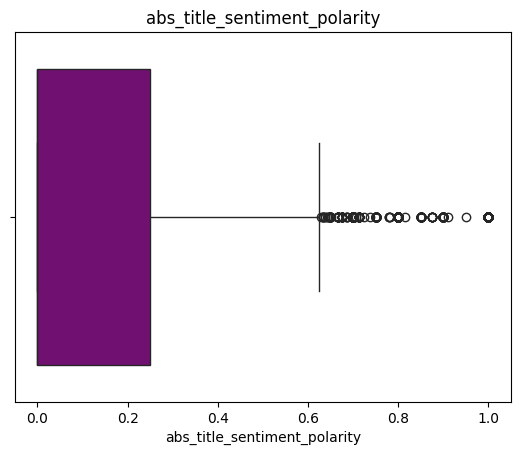

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
18               11.0             103.0         0.689320               1.0   
33               10.0             597.0         0.531732               1.0   
96                9.0             168.0         0.778481               1.0   
...               ...               ...              ...               ...   
39600            11.0            1166.0         0.508254               1.0   
39604            16.0            1020.0         0.421937               1.0   
39610            11.0             318.0         0.540000               1.0   
39631            13.0             746.0         0.465306               1.0   
39640            12.0             328.0         0.696296               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

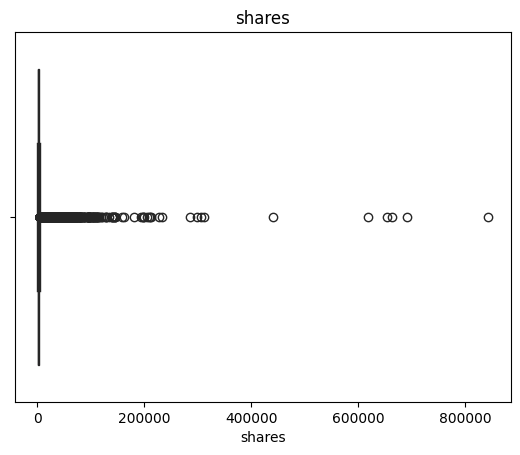

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
13                9.0             285.0         0.744186               1.0   
16                8.0            1118.0         0.512397               1.0   
18               11.0             103.0         0.689320               1.0   
19                8.0            1207.0         0.410579               1.0   
36               10.0            1244.0         0.417547               1.0   
...               ...               ...              ...               ...   
39588            10.0             759.0         0.523352               1.0   
39595            12.0             334.0         0.573171               1.0   
39598            11.0               0.0         0.000000               0.0   
39615            11.0               0.0         0.000000               0.0   
39621             9.0             468.0         0.582781               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

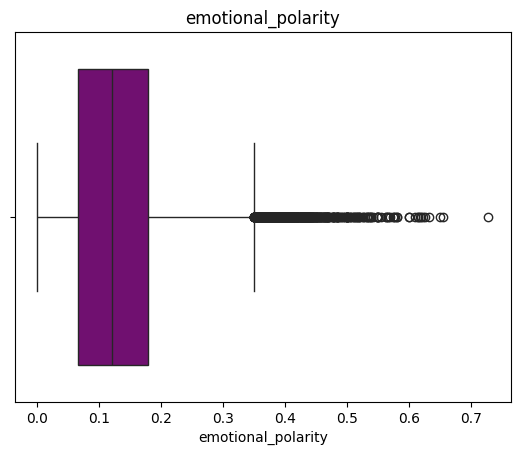

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
180               7.0             144.0         0.591549               1.0   
234               7.0             665.0         0.595166               1.0   
261              13.0             310.0         0.612457               1.0   
274              11.0             221.0         0.660550               1.0   
304              12.0             337.0         0.611987               1.0   
...               ...               ...              ...               ...   
38867            11.0              79.0         0.657895               1.0   
38937             9.0             656.0         0.411856               1.0   
39007            11.0             178.0         0.656977               1.0   
39021             9.0             170.0         0.565476               1.0   
39238             9.0             586.0         0.455342               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

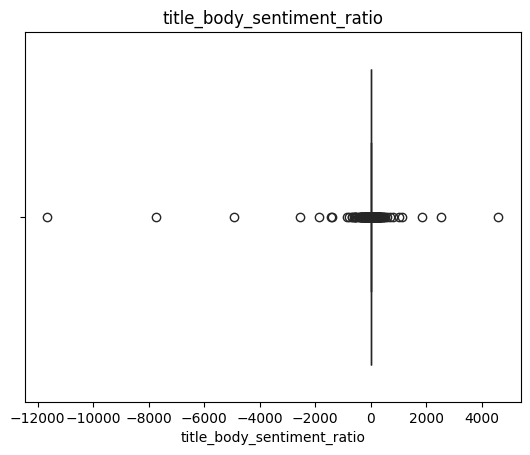

Anomalies: 
        n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
12                9.0             274.0         0.609195               1.0   
13                9.0             285.0         0.744186               1.0   
14                8.0             259.0         0.562753               1.0   
15               12.0             682.0         0.459542               1.0   
18               11.0             103.0         0.689320               1.0   
...               ...               ...              ...               ...   
39629            13.0             209.0         0.656863               1.0   
39631            13.0             746.0         0.465306               1.0   
39637            13.0            1629.0         0.425711               1.0   
39640            12.0             328.0         0.696296               1.0   
39641            10.0             442.0         0.516355               1.0   

       n_non_stop_unique_tokens  num_hrefs  num_se

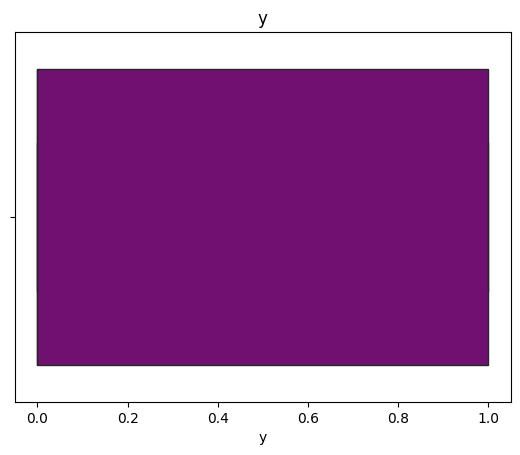

Anomalies: 
 Empty DataFrame
Columns: [n_tokens_title, n_tokens_content, n_unique_tokens, n_non_stop_words, n_non_stop_unique_tokens, num_hrefs, num_self_hrefs, num_imgs, num_videos, average_token_length, num_keywords, data_channel_is_lifestyle, data_channel_is_entertainment, data_channel_is_bus, data_channel_is_socmed, data_channel_is_tech, data_channel_is_world, kw_min_min, kw_max_min, kw_avg_min, kw_min_max, kw_max_max, kw_avg_max, kw_min_avg, kw_max_avg, kw_avg_avg, self_reference_min_shares, self_reference_max_shares, self_reference_avg_sharess, weekday_is_monday, weekday_is_tuesday, weekday_is_wednesday, weekday_is_thursday, weekday_is_friday, weekday_is_saturday, weekday_is_sunday, is_weekend, LDA_00, LDA_01, LDA_02, LDA_03, LDA_04, global_subjectivity, global_sentiment_polarity, global_rate_positive_words, global_rate_negative_words, rate_positive_words, rate_negative_words, avg_positive_polarity, min_positive_polarity, max_positive_polarity, avg_negative_polarity, min_negative

In [136]:
# BEFORE OUTLIER HANDLING --> visualize outliers
cols_remaining = df.columns.tolist() # what columns are left in the dataset

num_anomalies_1 = []

# for each of the remaining columns print the anomalies and see if there needs to be any adjustments made --> generally high rates of anomalies
for col in cols_remaining:
    num = anomaly_detection(col, True)
    num_anomalies_1.append(num)

#### Scaling

In [137]:
#CHLOE handling skew and outliers
scaler = RobustScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# used later
X_train_original = X_train.copy()
X_test_original = X_test.copy()
y_train_original = y_train.copy()

#### Smote

In [138]:
#CHLOE TRAIN SMOTE NAN AND CLASS BALANCING
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

cat_indices = [X_train.columns.get_loc(c) for c in binary_cols if c in X_train.columns]
sm = SMOTENC(categorical_features=cat_indices, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#### Feature selection

In [139]:
# CHLOE FEATURE SELECTION
selector_model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)
selector_model.fit(X_train_res, y_train_res)

selection = SelectFromModel(selector_model, threshold="1.25*median", prefit=True)

# Transform
X_train = pd.DataFrame(
    selection.transform(X_train_res),
    columns=X_train_res.columns[selection.get_support()]
)
X_test = pd.DataFrame(
    selection.transform(X_test),
    columns=X_train_res.columns[selection.get_support()]
)

y_train = y_train_res

selected_features_names = X_train.columns
print(f"Selected {len(selected_features_names)} features.")

Selected 22 features.


c:\Users\Chloe\anaconda3\envs\CIS4930\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Chloe\anaconda3\envs\CIS4930\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Training and Testing

In [140]:
# only need to declare the variable once
labels = ['Not Viral', 'Viral']

Note - grid search has been commented out to reduce runtime. The best hyperparameters found are commented at the bottom of the cells.

#### 1. Logistic Regression Model

In [141]:
# # Logistic Regression hyperparameter grid
# lr_params = {
#     'C': [0.01, 0.1, 1, 10],
#     'solver': ['lbfgs'],
#     'penalty': ['l2'],
#     'max_iter': [1000]
# }

# lr_grid = GridSearchCV(
#     LogisticRegression(),
#     lr_params,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1
# )

# lr_grid.fit(X_train, y_train.to_numpy())

# print("Best LR Params:", lr_grid.best_params_)
# print("Best LR Score:", lr_grid.best_score_)

# # Final tuned LR model
# lr_best = lr_grid.best_estimator_
# y_pred_lr_tuned = lr_best.predict(X_test)

# # Best LR Params: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

In [142]:
# Use best hyperparameters
best_lr_model = LogisticRegression(
    C=0.1,
    max_iter=1000,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)

# fit the model
best_lr_model.fit(X_train, y_train.values.ravel())

# make predictions
y_pred_lr = best_lr_model.predict(X_test)

Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.65      0.65      0.65      4017
       Viral       0.64      0.63      0.64      3912

    accuracy                           0.64      7929
   macro avg       0.64      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929



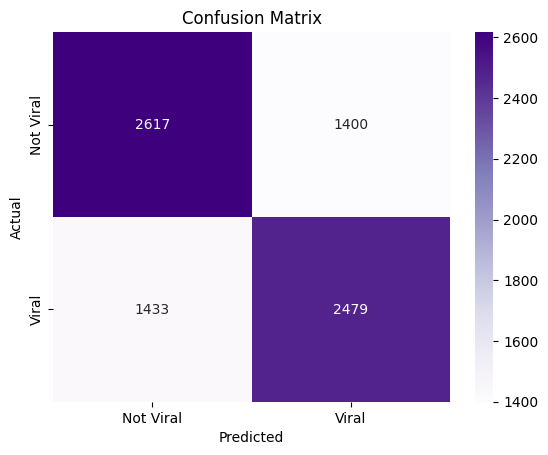

In [143]:
# evaluate linear regression performance
print("Classification Report:\n")
print(classification_report(y_test.values.ravel(), y_pred_lr, target_names=labels))

cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Purples', xticklabels = labels, yticklabels = labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

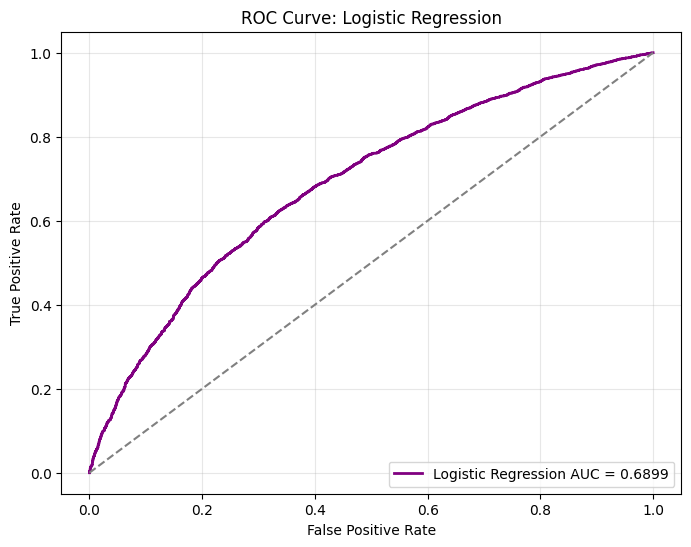

In [144]:
#Logistic regression ROC/AUC
y_probability_lr = best_lr_model.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test.values.ravel(), y_probability_lr)

roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='purple', lw=2, label=f'Logistic Regression AUC = {roc_auc_lr:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#### 2. KNN

In [145]:
# # find the optimal value of k
# k_values = range(1, 40)
# accuracy_scores = []

# for k in k_values:
#     # Build KNN classifier for each k
#     knn = KNeighborsClassifier(n_neighbors = k, weights = 'uniform')
#     knn.fit(X_train, y_train.to_numpy())
    
#     # Predict on test set
#     pred = knn.predict(X_test)
    
#     # Calculate accuracy
#     acc = accuracy_score(y_test.to_numpy(), pred)
#     accuracy_scores.append(acc)

# plt.plot(k_values, accuracy_scores, marker='o', linestyle='dashed', color='green')
# plt.xlabel("K Value")
# plt.ylabel("Accuracy")
# plt.title("Finding Optimal K for Binary Classification")
# plt.grid(True)
# plt.show()

# best_k = k_values[np.argmax(accuracy_scores)]
# print(f"Best K found: {best_k} with Accuracy: {max(accuracy_scores):.4f}")

# # Best K found: 31

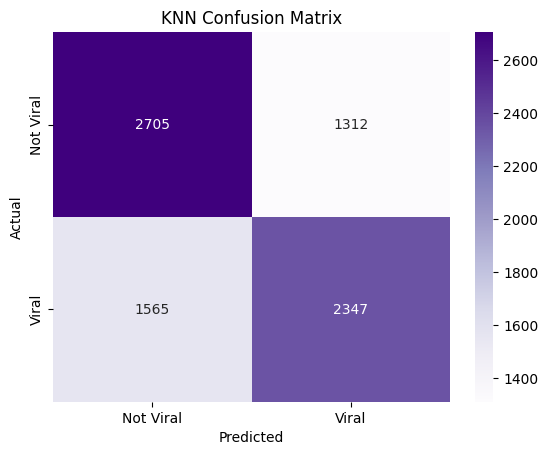

--- FINAL KNN RESULTS (K=31) ---
Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.63      0.67      0.65      4017
       Viral       0.64      0.60      0.62      3912

    accuracy                           0.64      7929
   macro avg       0.64      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929



In [146]:
# train knn with optimal k
knn_best = KNeighborsClassifier(n_neighbors=31, weights='uniform')

# fit the model
knn_best.fit(X_train, y_train.values.ravel()) 

# prediction
y_pred_knn = knn_best.predict(X_test)

# visualize success of knn
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.show()

# Evaluation
print(f"--- FINAL KNN RESULTS (K=31) ---")
print("Classification Report:\n")
print(classification_report(y_test.values.ravel(), y_pred_knn, target_names=labels))

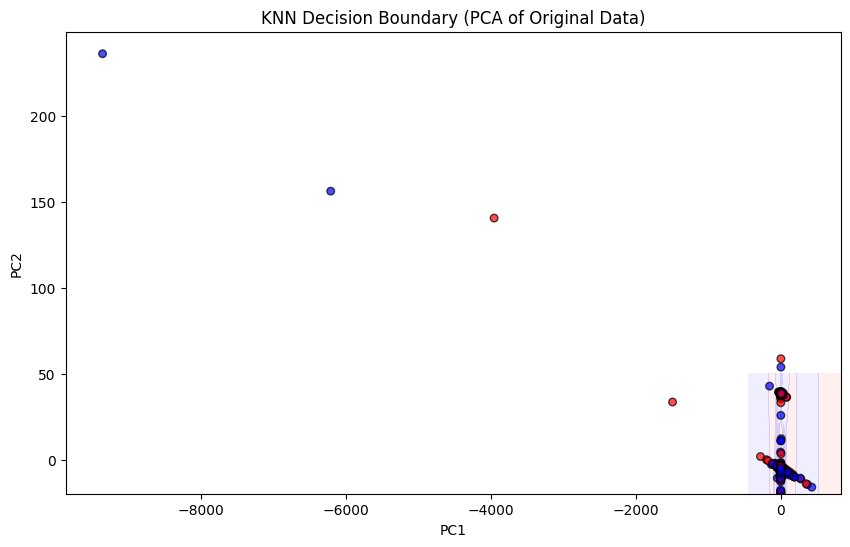

In [147]:
# PCA visualization
X_train_raw_df = pd.DataFrame(X_train_original)   # copy before smote + feature selection
y_train_raw_df = pd.Series(y_train_original)

# Subsample
X_vis = X_train_raw_df.sample(3000, random_state=42)
y_vis = y_train_raw_df.loc[X_vis.index]

# PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_vis)
X_test_pca = pca.transform(X_test_original)

# KNN for decision boundary
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_pca, y_vis.values.ravel())

# Meshgrid
h = 1
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, cmap=ListedColormap(['#FFCCCC', '#CCCCFF']), alpha=0.3)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1],
            c=y_test.values.ravel(),
            cmap=ListedColormap(['#FF0000', '#0000FF']),
            edgecolor='k', s=30, alpha=0.7)
plt.title("KNN Decision Boundary (PCA of Original Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


#### 3. Random Forest Classifier

In [148]:
# # Random Forest hyperparameter grid
# rf_params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 15, 20],
#     'max_features': ['sqrt', 'log2']
# }

# rf_grid = GridSearchCV(
#     RandomForestClassifier(random_state=42, n_jobs=-1),
#     rf_params,
#     cv=3,
#     scoring='accuracy',
#     n_jobs=-1
# )

# rf_grid.fit(X_train, y_train.to_numpy())

# print("Best RF Params:", rf_grid.best_params_)
# print("Best RF Score:", rf_grid.best_score_)

# # Final tuned RF model
# rf_best = rf_grid.best_estimator_
# y_pred_rf_tuned = rf_best.predict(X_test)

# # Best RF Params: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}


Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.67      0.64      0.65      4017
       Viral       0.65      0.67      0.66      3912

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



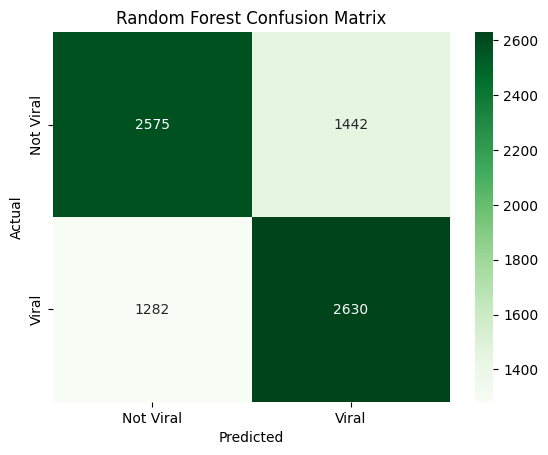

                      Feature  Importance
10                 kw_avg_avg    0.073698
9                  kw_max_avg    0.067766
11  self_reference_min_shares    0.059649
16                     LDA_02    0.057138
7                  kw_avg_max    0.055520
18                     LDA_04    0.049516
15                     LDA_01    0.049090
1             n_unique_tokens    0.048413
14                     LDA_00    0.047929
19        global_subjectivity    0.046225
20  global_sentiment_polarity    0.046012
12  self_reference_max_shares    0.045078
6                  kw_max_min    0.044556
0            n_tokens_content    0.044406
3        average_token_length    0.044129


In [149]:
# random Forest w/ tuned parameters
best_rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

best_rf_model.fit(X_train, y_train.values.ravel())
y_pred_rf = best_rf_model.predict(X_test)

# Evaluation
print("\nClassification Report:\n")
print(classification_report(y_test.values.ravel(), y_pred_rf, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test.values.ravel(), y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# Feature importance
importances = best_rf_model.feature_importances_
feature_names = X_train.columns
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)
print(feature_df)

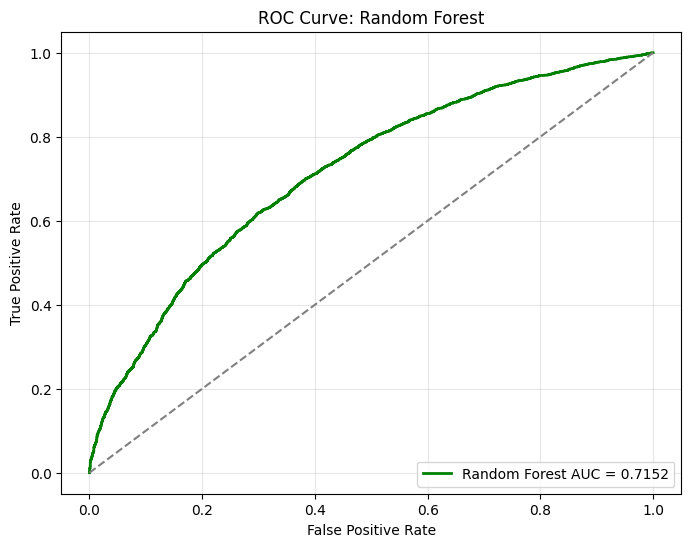

In [150]:
#random forest ROC/AUC
y_probability_rf = best_rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test.values.ravel(), y_probability_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest AUC = {roc_auc_rf:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\Chloe\AppData\Local\Temp\ipykernel_7744\1378287464.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')


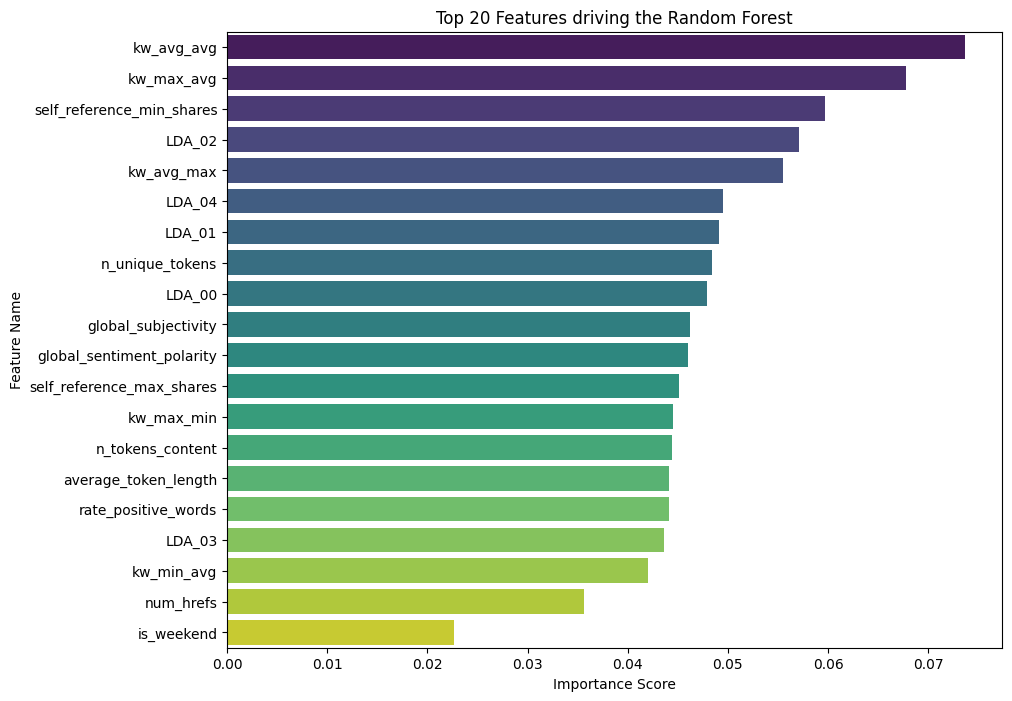

Top 5 Most Important Features:
                      Feature  Importance
10                 kw_avg_avg    0.073698
9                  kw_max_avg    0.067766
11  self_reference_min_shares    0.059649
16                     LDA_02    0.057138
7                  kw_avg_max    0.055520


In [151]:
# Get feature importance from the trained model
importances = best_rf_model.feature_importances_

# Create a DataFrame to organize them
# Assuming X_train was a DataFrame originally. If it was a numpy array, 
# we generate generic names Feature_0, Feature_1, etc.
try:
    feature_names = X_train.columns
except:
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')
plt.title("Top 20 Features driving the Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

print("Top 5 Most Important Features:")
print(feature_imp_df.head(5))

#### 4. XGBoost

In [152]:
# # Define the model
# xgb = XGBClassifier(random_state=42, objective='binary:logistic', n_jobs=-1)

# # Define hyperparameter grid
# xgb_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0]
# }

# # Grid search with CV
# xgb_grid = GridSearchCV(
#     xgb,
#     xgb_param_grid,
#     cv=3,
#     scoring='accuracy',
#     n_jobs=-1
# )

# xgb_grid.fit(X_train, y_train)

# print("Best XGBoost Params:", xgb_grid.best_params_)
# print("Best XGBoost Score:", xgb_grid.best_score_)

# # Best XGBoost Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}


Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.67      0.64      0.65      4017
       Viral       0.65      0.67      0.66      3912

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



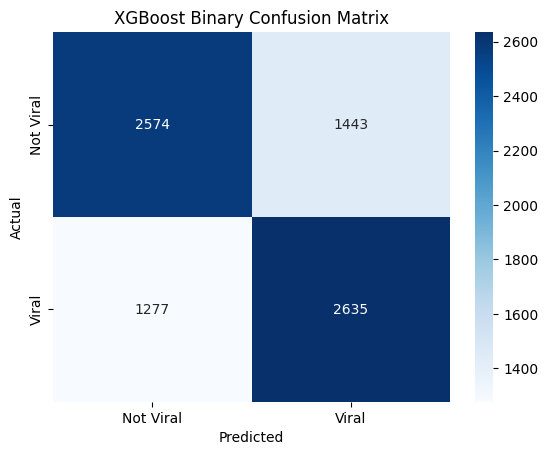

In [153]:
xgb_best_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.7,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1
)
xgb_best_model.fit(X_train, y_train)
y_pred_xgb = xgb_best_model.predict(X_test)

# evaluate
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb, target_names=labels))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Binary Confusion Matrix")
plt.show()

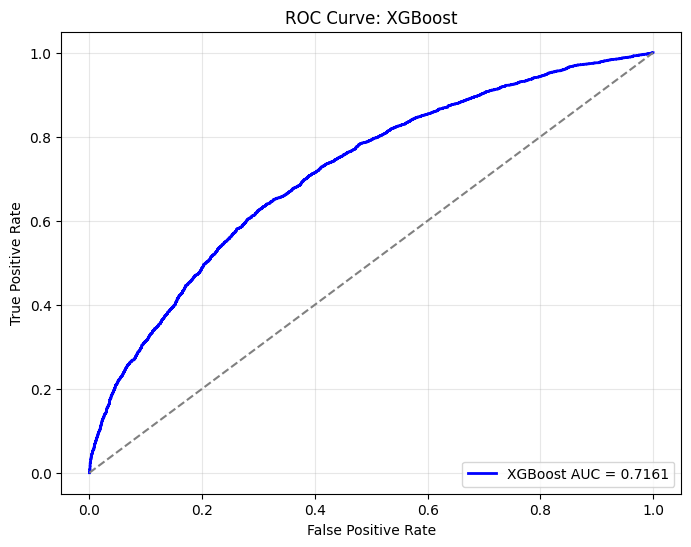

In [154]:
#xgboost AUC/ROC
y_probability_xgb = xgb_best_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probability_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost AUC = {roc_auc_xgb:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XGBoost')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#### 5. Stacking

In [155]:
# from sklearn.model_selection import GridSearchCV

# estimators = [
#     ('rf', best_rf_model),  # from tuned Random Forest
#     ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
#     ('lr', LogisticRegression(random_state=42))
# ]

# stacking_model = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(),
#     n_jobs=-1
# )

# param_grid = {
#     'final_estimator__C': [0.01, 0.1, 1, 10]
# }

# grid = GridSearchCV(stacking_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid.fit(X_train, y_train.values.ravel())

# stack_best = grid.best_estimator_
# y_pred_stack = stack_best.predict(X_test)

# print("Best C for final estimator:", grid.best_params_['final_estimator__C'])

# # Best C for final estimator: 1


Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.67      0.65      0.66      4017
       Viral       0.65      0.67      0.66      3912

    accuracy                           0.66      7929
   macro avg       0.66      0.66      0.66      7929
weighted avg       0.66      0.66      0.66      7929



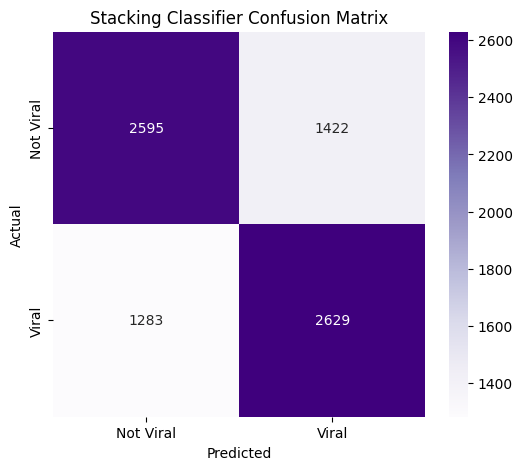

In [156]:
# define base learners w/ tuned models
estimators = [
    ('rf', best_rf_model),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(random_state=42))
]
# define the stacking model w/ the best final estimator parameter
stacking_best_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=1, random_state=42),
    n_jobs=-1
)
stacking_best_model.fit(X_train, y_train.values.ravel())
y_pred_stack = stacking_best_model.predict(X_test)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test.values.ravel(), y_pred_stack, target_names=labels))

# Confusion matrix
cm_stack = confusion_matrix(y_test.values.ravel(), y_pred_stack)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Stacking Classifier Confusion Matrix")
plt.show()

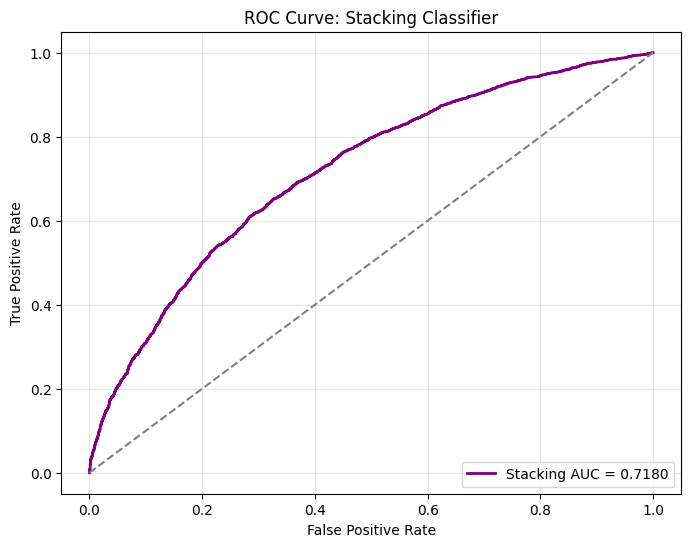

In [157]:
y_probability_stacking = stacking_best_model.predict_proba(X_test)[:, 1]

fpr_stack, tpr_stack, thresholds_stack = roc_curve(y_test.values.ravel(), y_probability_stacking)

roc_auc_stack = auc(fpr_stack, tpr_stack)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_stack, tpr_stack, color='purple', lw=2, label=f'Stacking AUC = {roc_auc_stack:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Stacking Classifier')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#### 6. Support Vector Machine

In [158]:
# # define parameter grid
# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'loss': ['hinge', 'squared_hinge'],
#     'max_iter': [1000, 5000, 10000]
# }

# # GridSearchCV
# grid = GridSearchCV(
#     estimator=LinearSVC(random_state=42),
#     param_grid=param_grid,
#     cv=5,                  # 5-fold cross-validation
#     scoring='accuracy',    # you can also try 'f1' if dataset is imbalanced
#     n_jobs=-1
# )

# # fit
# grid.fit(X_train, y_train.values.ravel())

# # best model
# best_svm = grid.best_estimator_

# print("Best hyperparameters:", grid.best_params_)

# # Best hyperparameters: {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 1000}



Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.64      0.64      0.64      4017
       Viral       0.63      0.64      0.64      3912

    accuracy                           0.64      7929
   macro avg       0.64      0.64      0.64      7929
weighted avg       0.64      0.64      0.64      7929



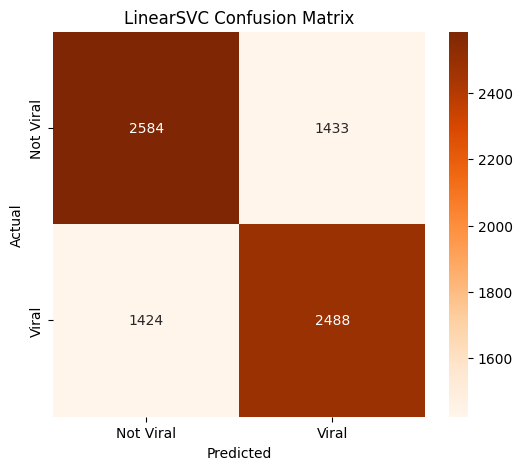

In [159]:
best_svm_model = LinearSVC(
    C=0.1,
    loss='squared_hinge',
    max_iter=1000,
    random_state=42
)
best_svm_model.fit(X_train, y_train.values.ravel())
y_pred_svm = best_svm_model.predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test.values.ravel(), y_pred_svm, target_names=labels))

cm_svm = confusion_matrix(y_test.values.ravel(), y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LinearSVC Confusion Matrix")
plt.show()

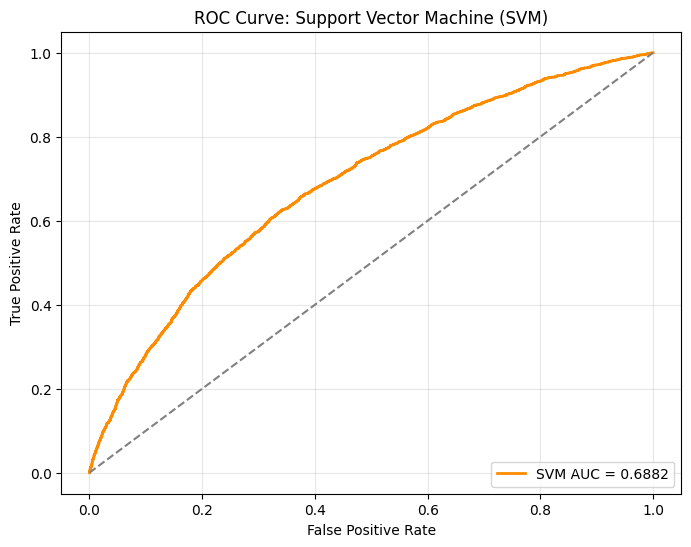

In [160]:
y_probability_svm = best_svm_model.decision_function(X_test)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test.values.ravel(), y_probability_svm)

roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label=f'SVM AUC = {roc_auc_svm:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Support Vector Machine (SVM)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#### 7. Neural Network

In [161]:
# Define nn architecture
class ClassificationNN(nn.Module):
    def __init__(self, input_dim, dropout, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,input_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(input_dim // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [162]:
# convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor  = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

In [163]:
# # Find best hyperparameters
# param_grid = {
#     "lr": [1e-2, 5e-2, 1e-3],
#     "dropout": [0.2, 0.3, 0.5],
#     "batch_size": [32, 64]
# }

# best_acc = 0
# best_params = None
# best_model = None

# criterion = nn.CrossEntropyLoss()

# for lr in param_grid["lr"]:
#     for dropout in param_grid["dropout"]:
#         for batch in param_grid["batch_size"]:
#             train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

#             model = ClassificationNN(
#                 input_dim=X_train_tensor.shape[1],
#                 dropout=dropout,
#                 num_classes=2
#             )
            
#             optimizer = optim.Adam(model.parameters(), lr=lr)

#             # train for a few epochs
#             model.train()
#             for epoch in range(5):  
#                 for X_batch, y_batch in train_loader:
#                     optimizer.zero_grad()
#                     outputs = model(X_batch)
#                     loss = criterion(outputs, y_batch)
#                     loss.backward()
#                     optimizer.step()

#             # evaluate on test set
#             model.eval()
#             with torch.no_grad():
#                 outputs = model(X_test_tensor)
#                 preds = torch.argmax(outputs, dim=1)
#                 acc = (preds == y_test_tensor).float().mean().item()

#             if acc > best_acc:
#                 best_acc = acc
#                 best_params = (lr, dropout, batch)
#                 best_model = model

# print("Best Neural Network Params:")
# print(f"Learning Rate: {best_params[0]}")
# print(f"Dropout: {best_params[1]}")
# print(f"Batch Size: {best_params[2]}")
# print(f"Validation Accuracy: {best_acc:.4f}")

# # Best Neural Network Params:
# # Learning Rate: 0.001
# # Dropout: 0.2
# # Batch Size: 32
# # Validation Accuracy: 0.6519


In [164]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [165]:
model = ClassificationNN(X_train_tensor.shape[1], 0.2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Epoch 10/20 | Train Loss: 0.6296 | Test Loss: 0.6256
Epoch 20/20 | Train Loss: 0.6221 | Test Loss: 0.6249
Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.66      0.64      0.65      4017
       Viral       0.64      0.67      0.65      3912

    accuracy                           0.65      7929
   macro avg       0.65      0.65      0.65      7929
weighted avg       0.65      0.65      0.65      7929



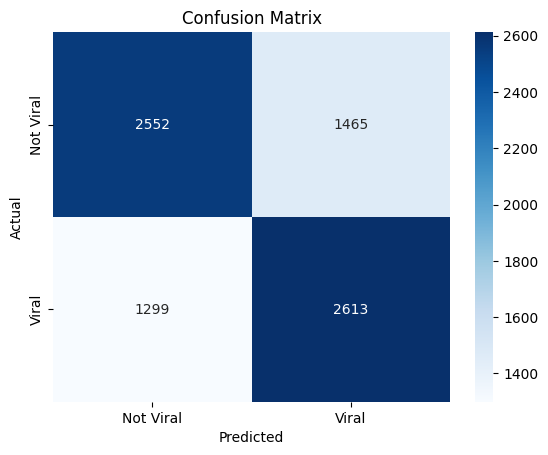

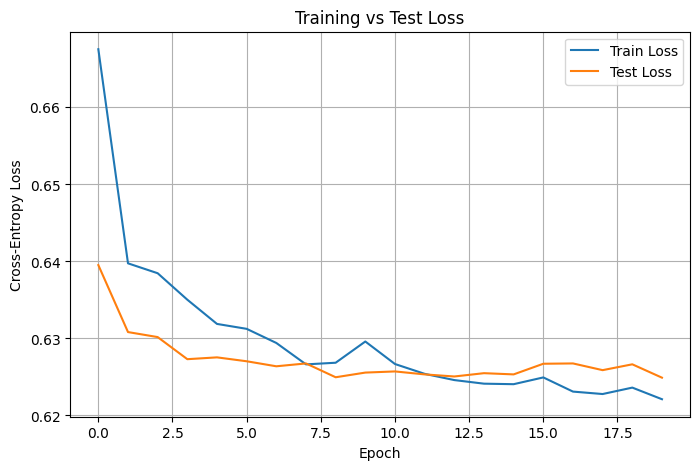

In [166]:
train_losses = []
test_losses = []

n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * X_batch.size(0)

    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Test loss
    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_test_loss += loss.item() * X_batch.size(0)

    test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(test_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

#evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1)

print("Classification Report:\n")
print(classification_report(y_test_tensor.numpy(), y_pred.numpy(), target_names=labels))

cm = confusion_matrix(y_test_tensor.numpy(), y_pred.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

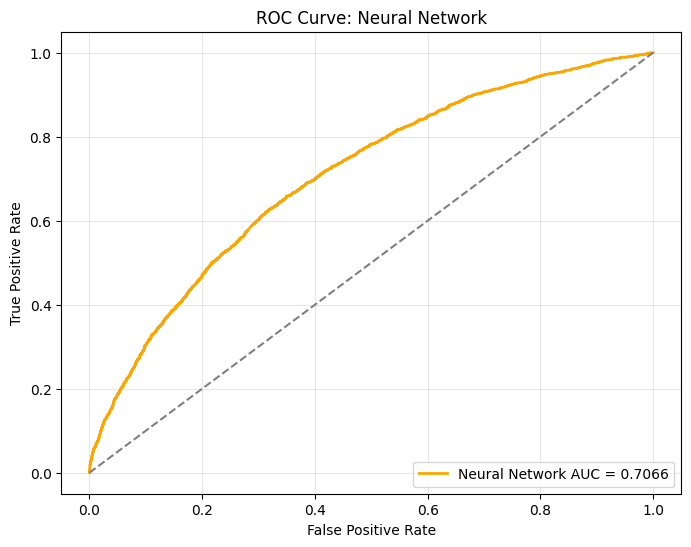

In [167]:
#NN roc/auc
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    # Use softmax to get probabilities summing to 1, then take class 1
    y_probabilities_nn = torch.softmax(outputs, dim=1)[:, 1].numpy()

fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_probabilities_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='orange', lw=2, label=f'Neural Network AUC = {roc_auc_nn:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Neural Network')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#### 8. Decision Tree

In [168]:
# # Hyperparameter grid for Decision Tree
# dt_params = {
#     'max_depth': [5, 10, 15, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'criterion': ['gini', 'entropy']
# }

# # GridSearchCV to find best parameters
# dt_grid = GridSearchCV(
#     DecisionTreeClassifier(random_state=42),
#     dt_params,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1
# )

# # Fit to training data
# dt_grid.fit(X_train, y_train.to_numpy())

# # Best parameters and score
# print("Best Decision Tree Params:", dt_grid.best_params_)
# print("Best Decision Tree Score:", dt_grid.best_score_)

# # Final tuned model
# dt_best = dt_grid.best_estimator_
# y_pred_dt = dt_best.predict(X_test)

# # Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


Classification Report:

              precision    recall  f1-score   support

   Not Viral       0.64      0.62      0.63      4017
       Viral       0.62      0.65      0.63      3912

    accuracy                           0.63      7929
   macro avg       0.63      0.63      0.63      7929
weighted avg       0.63      0.63      0.63      7929



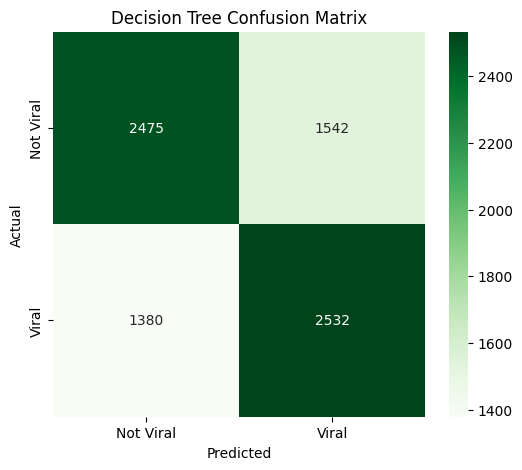

In [ ]:
dt_best_model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=2,
    random_state=42
)

dt_best_model.fit(X_train, y_train.values.ravel())
y_pred_dt = dt_best_model.predict(X_test)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test.values.ravel(), y_pred_dt, target_names=labels))

# Confusion matrix
cm_dt = confusion_matrix(y_test.values.ravel(), y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree Confusion Matrix")
plt.show()

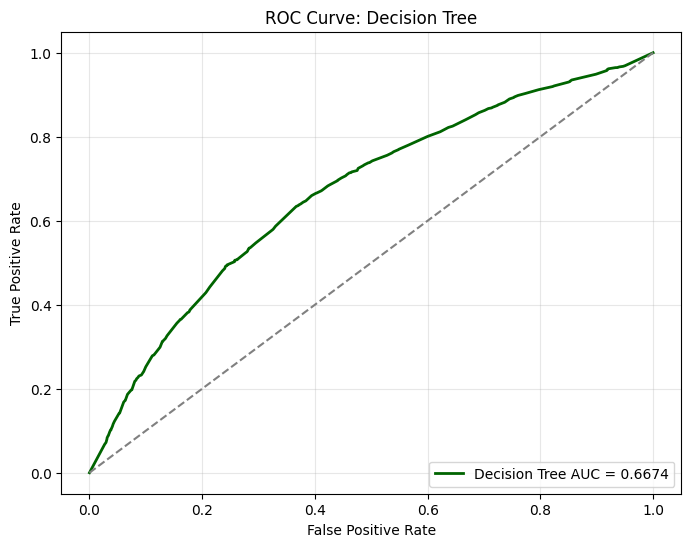

In [170]:
y_probability_dt = dt_best_model.predict_proba(X_test)[:, 1]

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test.values.ravel(), y_probability_dt)

roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkgreen', lw=2, label=f'Decision Tree AUC = {roc_auc_dt:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Decision Tree')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\Chloe\AppData\Local\Temp\ipykernel_7744\2180662482.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')


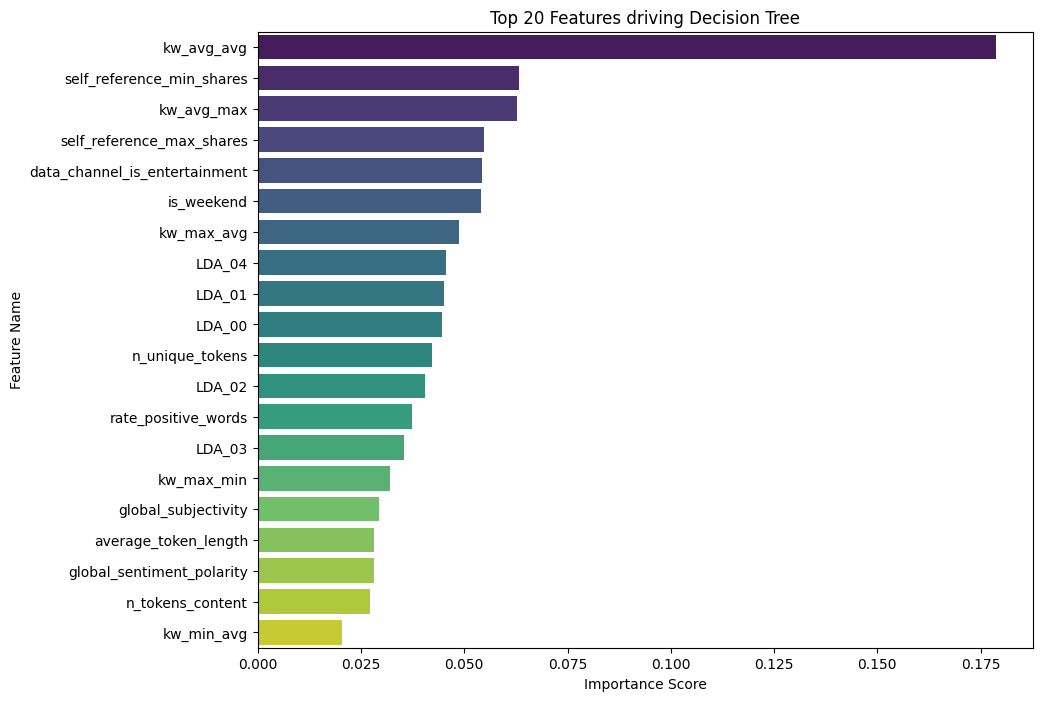

Top 5 Most Important Features:
                          Feature  Importance
10                     kw_avg_avg    0.178698
11      self_reference_min_shares    0.063163
7                      kw_avg_max    0.062693
12      self_reference_max_shares    0.054756
4   data_channel_is_entertainment    0.054257


In [171]:
# feature importance
importances = dt_best_model.feature_importances_
try:
    feature_names = X_train.columns
except AttributeError:
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot Top 20 Features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(20), palette='viridis')
plt.title("Top 20 Features driving Decision Tree")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

# Print top 5 features
print("Top 5 Most Important Features:")
print(feature_imp_df.head(5))